In [ ]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
!wget https://github.com/maziarraissi/PINNs/raw/master/main/Data/NLS.mat
!wget https://github.com/maziarraissi/PINNs/raw/master/main/Data/AC.mat

--2021-05-10 11:42:51--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2021-05-10 11:42:51--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2021-05-10 11:42:52 (13.1 MB/s) - ‘burgers_shock.mat’ s

In [ ]:
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.optimizers import Adam

from keras.layers.merge import add, concatenate

import tensorflow_probability as tfp
import scipy.io

from toolz import pipe, juxt, compose
import numpy as np

import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')

In [ ]:
import json

from requests import post
from datetime import datetime

def get_model_descr(model):
    x = []
    model.summary(print_fn=x.append)
    return model.get_config(), x

def save_experiment(experiment):
    return
    post("http://4d3b0181b932.ngrok.io", json={
        "payload": experiment,
        "date": datetime.today().strftime("%H:%M:%S %d %B %Y")
    })

def ml_logging(model, losses, errors, kwargs):
    model_config, model_summary = get_model_descr(model)
    for k, v in kwargs.items():
        if isinstance(v, np.ndarray):
            kwargs[k] = v.tolist()
        elif callable(v):
            kwargs[k] = str(v)
    save_experiment({
        # "model": {
        #     "config": model_config,
        #     "summary": model_summary
        # },
        "kwargs": kwargs,
        "losses": [float(x) for x in losses],
        "errors": [float(x) for x in errors]
    })
    return model, losses

In [ ]:
def error_sol(sol, model, xs):
    ms, ss = model(xs), sol(xs)
    assert ms.shape == ss.shape
    return tf.reduce_mean(tf.square(model(xs) - sol(xs)))

def error_stored(filename):
    data = scipy.io.loadmat(filename)
    t = data['t' if 't' in data else 'tt'].flatten()[::3,None]
    x = data['x'].flatten()[::3,None]
    Exact = np.real(data['usol' if 'usol' in data else 'uu']).T[::3,::3].reshape((-1,1))
    X, T = np.meshgrid(t, x)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    def error_f(sol, model, xs):
        ms = model(X_star)
        assert ms.shape == Exact.shape
        return tf.reduce_mean(tf.square(ms - Exact))
    return error_f

def error_schrodinger_stored(filename):
    data = scipy.io.loadmat(filename)
    t = data['tt'].flatten()[::3,None]
    x = data['x'].flatten()[::3,None]
    T, X = np.meshgrid(t, x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    Exact = data['uu'][::3,::3].T
    Exact_u = np.real(Exact)
    Exact_v = np.imag(Exact)
    Exact_h = np.sqrt(Exact_u**2 + Exact_v**2).reshape((-1,))
    def error_f(sol, model, xs):
        ms = tf.norm(model(X_star), axis=1)
        assert ms.shape == Exact_h.shape
        return tf.reduce_mean(tf.square(ms - Exact_h))
    return error_f

def function_factory(model, loss):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.

    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).

    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss()

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        # if (f.iter-1) % 50 == 0:
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.history = []
    return f

def general_experiment(
    border_xs, border_ys,
    inside_xs_builder,
    border_builder, equation_builder,
    input_dim, output_dim,
    model_builder, epochs, learning_rate, N_f, clip_grad=100,
    border_loss_multiplier=1,
    random_seed=1,
    x_min=0,x_max=1,
    error_f=error_sol,
    optimizers=[1, 0],
    sol=None,plot_callback=None,bm_callback=None,
    epochs_log_rate=100, loss_log_rate=50,
    logging=True, save_model=True
):
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    model = model_builder(input_dim, output_dim, x_min, x_max)
    model.compile()
    opt = Adam(learning_rate)

    losses = []
    errors = []
    grads = []
    best_model = None

    inside_xs = inside_xs_builder(N_f)
    ixv = tf.Variable(inside_xs, dtype=tf.float64)
    bxv = tf.Variable(border_xs, dtype=tf.float64)

    equation = equation_builder(model, ixv)
    border = border_builder(model, bxv, border_ys)

    # @tf.function
    def calc_loss(y_true_border):
        with tf.GradientTape() as model_tape:
            model_tape.watch(model.trainable_variables)
            loss_border = tf.reduce_mean(tf.square(border()))
            loss_inside = tf.reduce_mean(tf.square(equation(ixv)))
            loss = border_loss_multiplier * loss_border + loss_inside
        grad = model_tape.gradient(loss, model.trainable_variables)
        return loss, grad

    # @tf.function
    def fit(y_true_border):
        loss, gradient = calc_loss(y_true_border)
        grads = [(tf.clip_by_value(g, -clip_grad, clip_grad)) for g in gradient]
        # grads = gradient
        # n = tf.linalg.norm(tf.stack([tf.reshape(x, (-1,)) for x in grads]))
        # grads = [g / n * clip_grad for g in grads]
        opt.apply_gradients(zip(grads, model.trainable_variables))
        return loss, tf.linalg.norm(tf.concat([tf.reshape(g, (-1,)) for g in grads], axis=0))

    def run_epoch(epoch):
        nonlocal model
        nonlocal inside_xs
        # ixv.assign((inside_xs - np.min(inside_xs))*(epoch/epochs)+np.min(inside_xs))
        loss, g = fit(border_ys)
        if epoch % loss_log_rate == 0 and logging:
            print(f"Epoch {epoch}: loss={loss}")
        if logging and plot_callback and epoch % epochs_log_rate == 0:
            plot_callback(model)
        losses.append(loss)
        grads.append(g)
    
    if optimizers[0] == 1:
        for epoch in range(epochs + 1):
            run_epoch(epoch)
    if optimizers[1] == 1:
        f = function_factory(model, lambda: calc_loss(border_ys)[0])
        init_params = tf.dynamic_stitch(f.idx, model.trainable_variables)
        tfp.optimizer.lbfgs_minimize(
            f,
            initial_position=init_params,
            max_iterations=2000,
            tolerance=1e-4#1.0 * np.finfo(float).eps
        )
        losses.extend(map(float, f.history[3:]))
    errors.append(error_f(sol, model, inside_xs))

    if save_model:
        if bm_callback:
            bm_callback(model)
        best_model = tf.keras.models.clone_model(model)
        best_model.build(model.get_layer(index=0).input_shape[0])
        best_model.compile()
        best_model.set_weights(model.get_weights())

    if logging and plot_callback and best_model:
        print("best")
        plot_callback(best_model)
    
    if logging:
        plt.plot(np.arange(len(losses)), np.log10(losses))
        plt.title("log10(loss)")
        plt.show()
        plt.plot(np.arange(len(grads)), grads)
        plt.title("|g|^2")
        plt.show()

    return best_model, losses, errors

def plot_vs_sol_builder(sol, min_x=0, max_x=1, points=1000):
    def plot_callback(model):
        xs = np.linspace(min_x, max_x, points)
        ys = model(xs)[:,0]
        plt.plot(xs, ys, c='r', label="nn")
        plt.plot(xs, sol(xs), c='k', label="sol")
        plt.legend()
        plt.show()
    return plot_callback

def plot_2d_callback_builder(vmin=0, vmax=1, x0_min=0, x0_max=1, x1_min=0, x1_max=1):
    def plot_2d_callback(f):
        N = 100
        step = 1 / (N - 1)
        inside_xs = np.mgrid[x0_min:x0_max+step/10:step, x1_min:x1_max+step/10:step]
        shape = inside_xs.shape[1:]
        inside_xs = inside_xs.reshape(2, -1).T
        fs = f(inside_xs).numpy().reshape(shape)

        fig = plt.figure(figsize=(6, 5))
        h = plt.imshow(fs.T,
            cmap='seismic', 
            extent=[x0_min, x0_max, x1_min, x1_max], 
            origin='lower',
            aspect='auto',
            vmin=vmin,
            vmax=vmax
        )
        fig.colorbar(h)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    return plot_2d_callback

class simple_nn_builder_builder:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
    def __str__(self):
        return f"NN[{self.layer_sizes}]"
    def __repr__(self):
        return str(self)
    def __call__(self, input_dim, output_dim, x_min, x_max):
        inputs = Input(shape=(input_dim,))
        outputs = inputs
        outputs = Lambda(lambda x:(x-x_min)/(x_max-x_min))(outputs)
        for layer_size in self.layer_sizes:
            outputs = Dense(layer_size, "tanh")(outputs)
        # outputs = Dense(output_dim, kernel_initializer='ones')(outputs) # last layer is just linear
        outputs =  Dense(output_dim)(outputs) # last layer is just linear
        return Model(
            inputs=inputs,
            outputs=outputs
        )

def border_with_function_values_builder(model, bxv, y_true_border):
    @tf.function
    def border():
        y_pred_border = model(bxv)
        return y_pred_border - y_true_border
    return border

def linspace_inside_xs_builder_builder(min_x, max_x):
    def _inside_xs_builder(N_f):
        return np.array([
            [
                np.random.uniform(low, high)
                for low, high in zip(min_x, max_x)
            ]
            for _ in range(N_f)
        ])
    return _inside_xs_builder

def first_order_equation_builder_builder(equation):
    def equation_builder(model, ixv):
        @tf.function
        def equation_function(ixv):
            with tf.GradientTape() as g:
                y_pred_inside = model(ixv)
            dy_dx_inside = g.batch_jacobian(y_pred_inside, ixv)
            return equation(ixv, y_pred_inside, dy_dx_inside)
        return equation_function
    return equation_builder


def second_order_equation_builder_builder(equation):
    def equation_builder(model, ixv):
        @tf.function
        def equation_function(ixv):
            with tf.GradientTape() as g:
                with tf.GradientTape() as g2:
                    y_pred_inside = model(ixv)
                dy_dx_inside = g2.batch_jacobian(y_pred_inside, ixv)
            dy_dx2_inside = g.batch_jacobian(dy_dx_inside, ixv)
            return equation(ixv, y_pred_inside, dy_dx_inside, dy_dx2_inside)
        return equation_function
    return equation_builder

In [ ]:
def test_multiple(kwargs_array, default_kwargs={}):
    res = {}
    for random_seed in [1,2,3,4,5]:
        res[random_seed] = []
        for kwargs_orig in kwargs_array:
            kwargs = dict(kwargs_orig)
            kwargs["random_seed"] = random_seed
            ode = kwargs["ode"]
            del kwargs["ode"]
            print(f"    Solving {ode}")
            for k, v in default_kwargs.items():
                if not k in kwargs:
                    kwargs[k] = v
            model, losses, errors = general_experiment(**kwargs)
            ml_logging(model, losses, errors, {
                **kwargs,
                "random_seed": random_seed,
                "ode": ode
            })
            res[random_seed].append(float(losses[-1]))
    return res

# Equations

In [ ]:
def border_builder(model, bxv, border_ys):
    @tf.function
    def border():
        with tf.GradientTape() as g:
            y_pred_border = model(bxv)
        dy_dx_border = g.batch_jacobian(y_pred_border, bxv)
        return tf.stack([
            y_pred_border[:,0] - border_ys[0],
            dy_dx_border[:,0,0] - border_ys[1]
        ])
    return border

N_b = 100
border_side = np.linspace(0, 1, N_b)
border_0y = np.vstack([np.zeros(N_b), border_side]).T
border_1y = np.vstack([np.ones(N_b), border_side]).T
border_x0 = np.vstack([border_side, np.zeros(N_b)]).T
border_x1 = np.vstack([border_side, np.ones(N_b)]).T
border_xs = np.vstack([border_0y, border_1y, border_x0, border_x1])
border_ys = (np.power(border_xs[:,0], 2) + np.power(border_xs[:,1], 2)).reshape((-1, 1))

border2_0y = np.vstack([np.zeros(N_b), border_side]).T
border2_1y = np.vstack([np.ones(N_b), border_side]).T
border2_x0 = np.vstack([border_side, np.zeros(N_b)]).T
border2_x1 = np.vstack([border_side, np.ones(N_b)]).T
border2_xs = np.vstack([border2_0y, border2_1y, border2_x0, border2_x1])
border2_y_0y = np.power(border2_0y[:, 1], 3.)
border2_y_1y = (1 + np.power(border2_1y[:, 1], 3.)) * np.exp(-1)
border2_y_x0 = border2_x0[:, 0] * np.exp(-border2_x0[:, 0])
border2_y_x1 = (border2_x1[:, 0] + 1) * np.exp(-border2_x1[:, 0])
border2_ys = np.hstack([border2_y_0y, border2_y_1y, border2_y_x0, border2_y_x1]).reshape((-1, 1))

t_side = np.linspace(0, 1, N_b)
x_side = np.linspace(-1, 1, N_b)
border3_0x = np.vstack([np.zeros(N_b), x_side]).T
border3_tm1 = np.vstack([t_side, np.ones(N_b) * (-1)]).T
border3_t1 = np.vstack([t_side, np.ones(N_b)]).T
border3_xs = np.vstack([border3_0x, border3_tm1, border3_t1])
border3_y_0x = -np.sin(np.pi * border3_0x[:,1])
border3_y_tm1 = np.zeros(N_b)
border3_y_t1 = np.zeros(N_b)
border3_ys = np.hstack([border3_y_0x, border3_y_tm1, border3_y_t1]).reshape((-1, 1))

y_side = x_side = np.linspace(-1, 1, N_b)
border4_0y = np.vstack([np.zeros(N_b), y_side]).T
border4_1y = np.vstack([np.ones(N_b), y_side]).T
border4_x0 = np.vstack([x_side, np.zeros(N_b)]).T
border4_x1 = np.vstack([x_side, np.ones(N_b)]).T
border4_xs = np.vstack([border4_0y, border4_1y, border4_x0, border4_x1])
border4_ys = (np.log(1 + border4_xs[:,0] ** 2 + border4_xs[:,1] ** 2)).reshape((-1, 1))

border5_xs = np.vstack([np.zeros(N_b), np.linspace(-5, 5, N_b)]).T
border5_ys = np.vstack([2 / np.cosh(border5_xs[:,1]), np.zeros(N_b)]).T

border6_xs = np.vstack([np.zeros(N_b), np.linspace(-1, 1, N_b)]).T
border6_ys = (np.power(border6_xs[:,1], 2) * np.cos(np.pi * border6_xs[:,1])).reshape((-1,1))
def schrodinger_border_builder(model, bxv, border_ys):
    bxv1 = tf.Variable(np.vstack([
        np.linspace(0, np.pi / 2, N_b), np.ones(N_b) * (-5)
    ]).T)
    bxv2 = tf.Variable(np.vstack([
        np.linspace(0, np.pi / 2, N_b), np.ones(N_b) * 5
    ]).T)
    @tf.function
    def border():
        y0 = model(bxv)
        with tf.GradientTape() as g:
            y1 = model(bxv1)
        dy1 = g.batch_jacobian(y1, bxv1)
        with tf.GradientTape() as g:
            y2 = model(bxv2)
        dy2 = g.batch_jacobian(y2, bxv2)
        return tf.stack([
            y0 - border_ys,
            y1 - y2,
            dy1[:,:,1] - dy2[:,:,1]
        ])
    return border

def allencahn_border_builder(model, bxv, border_ys):
    bxv1 = tf.Variable(np.vstack([
        np.linspace(0, 1, N_b), np.ones(N_b) * (-1)
    ]).T)
    bxv2 = tf.Variable(np.vstack([
        np.linspace(0, 1, N_b), np.ones(N_b) * 1
    ]).T)
    @tf.function
    def border():
        y0 = model(bxv)
        with tf.GradientTape() as g:
            y1 = model(bxv1)
        dy1 = g.batch_jacobian(y1, bxv1)
        with tf.GradientTape() as g:
            y2 = model(bxv2)
        dy2 = g.batch_jacobian(y2, bxv2)
        return tf.stack([
            y0 - border_ys,
            y1 - y2,
            dy1[:,:,1] - dy2[:,:,1]
        ])
    return border

pde1_border_xs = linspace_inside_xs_builder_builder([0, 0], [0, 1])(N_b)

mu = 0.025
lmbd = 1/(2*mu)-np.sqrt(1/(4*mu**2)+4*np.pi**2)

x_side = np.linspace(-0.5, 1., N_b)
y_side = np.linspace(-0.5, 1.5, N_b)
border4_0y = np.vstack([np.ones(N_b)*(-0.5), y_side]).T
border4_1y = np.vstack([np.ones(N_b)*1., y_side]).T
border4_x0 = np.vstack([x_side, np.ones(N_b)*(-0.5)]).T
border4_x1 = np.vstack([x_side, np.ones(N_b)*1.5]).T
pde10_border_xs = np.vstack([border4_0y, border4_1y, border4_x0, border4_x1])

pde10_sol = lambda x: np.stack([
    1-np.exp(lmbd * x[:,0])*np.cos(2*np.pi*x[:,1]),
    lmbd/(2*np.pi)*np.exp(lmbd * x[:,0])*np.sin(2*np.pi*x[:,1]),
    (1/2)*(1-np.exp(2 * lmbd * x[:,0]))
]).T

from scipy.special import ellipj

experiments = [{
    "ode": "L-ODE1",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.ones(x.shape).reshape((-1,1))
}, {
    "ode": "L-ODE2",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]-y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(x).reshape((-1,1))
}, {
    "ode": "L-ODE3",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]+3*y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(-3 * x).reshape((-1,1))
}, {
    "ode": "L-ODE4",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]-10*y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(10 * x).reshape((-1,1))
}, {
    "ode": "L-ODE5",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]+15*y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(-15 * x).reshape((-1,1))
}, {
    "ode": "L-ODEn1",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([0., 10.]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, d2y: d2y[:,0,0,0] + 100 * y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.sin(10 * x).reshape((-1, 1))
}, {
    "ode": "L-ODEn2",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([1., 0.]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, d2y: d2y[:,0,0,0]+1001*dy[:,0,0]+1000*y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: 1000/999 * np.exp(-x)-1/999*np.exp(-1000*x)
}, {
    "ode": "L-ODEn3",
    "border_xs": np.array([[0.], [1.]]),
    "border_ys": np.array([[0.], [np.sin(1) / np.exp(0.2)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    # "plot_callback": plot_vs_sol_builder(lambda xs: np.exp(-xs / 5.) * np.sin(xs)),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, d2y: d2y[:,0,0,0] + dy[:,0,0] / 5. + y[:,0] + tf.exp(-x[:,0] / 5.) * tf.cos(x[:,0]) / 5.),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (np.exp(-x/5)*np.sin(x)).reshape((-1, 1))
}, {
    "ode": "NL-ODE1",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0] + (y[:,0] - 2 * x[:,0]) / x[:,0]),    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
}, {
    "ode": "NL-ODE2",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0] * x[:,0] + y[:,0] - 2 * x[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
}, {
    "ode": "NL-ODE3",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]+(y[:,0]*tf.cos(x[:,0])-1)/tf.sin(x[:,0])),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x)
}, {
    "ode": "NL-ODE4",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]*tf.sin(x[:,0])+y[:,0]*tf.cos(x[:,0])-1),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x)
}, {
    "ode": "NL-ODEn1",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[1.], [0.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: 4*tf.pow(x[:,0], 2)*dy2[:,0,0,0]+y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (-(1/2)*np.sqrt(x)*(np.log(x)-2)).reshape((-1, 1))
}, {
    "ode": "NL-ODEn2",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[0.], [3.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: tf.pow(x[:,0], 2)*dy2[:,0,0,0]+x[:,0]*dy[:,0,0]+y[:,0]-5*tf.pow(x[:,0],2)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.power(x,2)+np.sin(np.log(x))-np.cos(np.log(x))
}, {
    "ode": "SODE1",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([0., 10.]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x, y, dy: tf.stack([
        dy[:,1,0] + 100 * y[:,0],
        y[:,1] - dy[:,0,0]
    ])),
    "input_dim": 1,
    "output_dim": 2,
    "sol": lambda x: np.hstack([
        10*np.cos(10*x),
        np.sin(10*x)])
}, {
    "ode": "SODE2",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[0, 1, 1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [np.pi]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] - y[:,1] * y[:,2],
        dy[:,1,0] + y[:,0] * y[:,2],
        dy[:,2,0] + 0.5 * y[:,0] * y[:,1]
    ])),
    "input_dim": 1,
    "output_dim": 3,
    "sol": lambda x: np.array(ellipj(x, 0.5))[:3,:,0].T
}, {
    "ode": "SODE3",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[1, 0, 0]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [40]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] + 0.04 * y[:,0] - 1e4 * y[:,1] * y[:,2],
        dy[:,1,0] - 0.04 * y[:,0] + 1e4 * y[:,1] * y[:,2] + 3e7 * tf.pow(y[:,1], 2),
        dy[:,2,0] - 3e7 * tf.pow(y[:,1], 2)
    ])),
    "input_dim": 1,
    "output_dim": 3,
    "error_f": lambda x,y,z:-1
}, {
    "ode": "PDE1",
    "border_xs": pde1_border_xs,
    "border_ys": (lambda x: x[:,0] * np.exp(-np.power(x[:,0],2)))(pde1_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]+3*dy[:,0,1]),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: ((x[:,1]-3*x[:,0])*np.exp(-np.power(x[:,1]-3*x[:,0],2))).reshape((-1, 1))
}, {
    "ode": "PDE2",
    "border_xs": pde1_border_xs,
    "border_ys": (lambda x:np.sin(2*np.pi*x[:,0]))(pde1_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: 5*dy[:,0,0]+dy[:,0,1]-x[:,0]),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: ((1/5)*x[:,0]*x[:,1]-(1/50)*np.power(x[:,0],2)+np.sin(2*np.pi/5*(5*x[:,1]-x[:,0]))).reshape((-1, 1))
}, {
    "ode": "PDE3",
    "border_xs": border_xs,
    "border_ys": border_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: dy2[:, 0, 0, 0]+dy2[:, 0, 1, 1]-4),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: (np.power(x[:,0],2)+np.power(x[:,1],2)).reshape((-1, 1))
}, {
    "ode": "PDE4",
    "border_xs": border2_xs,
    "border_ys": border2_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: dy2[:,0,0,0]+dy2[:,0,1,1]-tf.exp(-x[:,0])*(x[:,0]-2+tf.pow(x[:,1],3)+6*x[:,1])),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: ((x[:,0]+np.power(x[:,1],3))*np.exp(-x[:,0])).reshape((-1, 1))
}, {
    "ode": "PDE5",
    "border_xs": border4_xs,
    "border_ys": border4_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([-1, -1], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: dy2[:,0,0,0]+dy2[:,0,1,1]+tf.exp(y[:,0])-1-x[:,0]**2-x[:,1]**2-4/((1+x[:,0]**2+x[:,1]**2)**2)),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: (np.log(1+np.power(x[:,0],2)+np.power(x[:,1],2))).reshape((-1, 1))
}, {
    "ode": "PDE6",
    "border_xs": border3_xs,
    "border_ys": border3_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, -1], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x, y, dy, dy2: 0.01/np.pi*dy2[:,0,1,1]-dy[:,0,0]-y[:,0]*dy[:,0,1]),
    "input_dim": 2,
    "output_dim": 1,
    "error_f": error_stored("burgers_shock.mat")
}, {
    "ode": "PDE7",
    "border_xs": border6_xs,
    "border_ys": border6_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 1], [-1, 1]),
    "border_builder": allencahn_border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x,y,dy,dy2:dy[:,0,0]-0.0001*dy2[:,0,1,1]+5*tf.pow(y[:,0],3)-5*y[:,0]),
    "input_dim": 2,
    "output_dim": 1,
    "error_f": error_stored("AC.mat")
}, {
    "ode": "PDE8",
    "border_xs": border_xs,
    "border_ys": np.zeros(border_xs.shape),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x,y,dy,dy2:(dy2[:,0,0,0]+dy2[:,0,1,1])+2*np.power(np.pi,2)*tf.sin(np.pi*x[:,0])*tf.sin(np.pi*x[:,1])),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: (np.sin(np.pi*x[:,0])*np.sin(np.pi*x[:,1])).reshape((-1, 1))
}, {
    "ode": "PDE9",
    "border_xs": border5_xs,
    "border_ys": border5_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, np.pi/2], [-5, 5]),
    "border_builder": schrodinger_border_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x,y,dy,dy2:tf.stack([
        -dy[:,1,0] + 0.5 * dy2[:,0,1,1] + tf.pow(tf.norm(y, axis=1), 2) * y[:,0],
        dy[:,0,0] + 0.5 * dy2[:,1,1,1] + tf.pow(tf.norm(y, axis=1), 2) * y[:,1]
    ])),
    "input_dim": 2,
    "output_dim": 2,
    "error_f": error_schrodinger_stored("NLS.mat")
}, {
    "ode": "PDE10",
    "border_xs": pde10_border_xs,
    "border_ys": pde10_sol(pde10_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([-0.5, -0.5], [1, 1.5]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x,y,dy,dy2:tf.stack([
        -0.025*(dy2[:,0,0,0]+dy2[:,0,1,1])+y[:,0]*dy[:,0,0]+y[:,1]*dy[:,0,1]+dy[:,2,0],
        -0.025*(dy2[:,0,0,0]+dy2[:,0,1,1])+y[:,0]*dy[:,1,0]+y[:,1]*dy[:,1,1]+dy[:,2,1],
        dy[:,0,0]+dy[:,1,1]
    ])),
    "input_dim": 2,
    "output_dim": 3,
    "sol": pde10_sol
}]
experiments=experiments[-10:]#[:1]
print(experiments[0]["ode"], experiments[-1]["ode"])

PDE1 PDE10


In [ ]:
def plot_robertson(model):
    xs = np.linspace(0, 40, 1000)
    ys = model(xs)
    for i in range(3):
        plt.plot(xs, ys[:,i], c='r', label=f"nn[{i+1}]")
    plt.legend()
    plt.show()

def plot_pde10_callback_builder(vmin=0, vmax=1, x0_min=0, x0_max=np.pi/2, x1_min=-5, x1_max=5):
    def plot_2d_callback(f):
        N = 100
        step = 1 / (N - 1)
        inside_xs = np.mgrid[x0_min:x0_max+step/10:step, x1_min:x1_max+step/10:step]
        shape = inside_xs.shape[1:]
        inside_xs = inside_xs.reshape(2, -1).T
        fs = f(inside_xs).numpy()[:,0].reshape(shape)

        fig = plt.figure(figsize=(6, 5))
        h = plt.imshow(fs.T,
            cmap='seismic', 
            extent=[x0_min, x0_max, x1_min, x1_max], 
            origin='lower',
            aspect='auto',
            vmin=vmin,
            vmax=vmax
        )
        fig.colorbar(h)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    return plot_2d_callback

def test_parameter(name, values, other_params):
    for value in values:
        print("\n" * 5)
        print(f"Testing {name}={value}")
        rlosses = test_multiple(kwargs_array=experiments, default_kwargs={
            **other_params,
            name: value
        })
        losses = [sum(rlosses[k][i] for k in rlosses.keys()) / len(rlosses.keys()) for i in range(len(rlosses[1]))]

# STOP RIGHT THERE CRIMINAL SCUM

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     # "logging": True
# }

# test_parameter("model_builder", [
#     simple_nn_builder_builder([16, 8, 4]),
#     simple_nn_builder_builder([32, 16, 8, 4]),
#     simple_nn_builder_builder([4, 8, 16]),
#     simple_nn_builder_builder([4, 8, 16, 32]),
#     simple_nn_builder_builder([10, 10, 10]),
#     simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     simple_nn_builder_builder([200, 200, 200, 200])
# ], default_kwargs)

In [ ]:
def test_multiple(kwargs_array, default_kwargs={}):
    res = {}
    random_seed = 1
    res[random_seed] = []
    for kwargs_orig in kwargs_array:
        kwargs = dict(kwargs_orig)
        kwargs["random_seed"] = random_seed
        ode = kwargs["ode"]
        del kwargs["ode"]
        print(f"    Solving {ode}")
        for k, v in default_kwargs.items():
            if not k in kwargs:
                kwargs[k] = v
        model, losses, errors = general_experiment(**kwargs)
        ml_logging(model, losses, errors, {
            **kwargs,
            "random_seed": random_seed,
            "ode": ode
        })
        res[random_seed].append(float(losses[-1]))
    return res

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     # "logging": True,
#     # "plot_callback": plot_robertson
#     # "plot_callback": plot_2d_callback_builder(vmin=-1, x1_min=-1) #pde6
#     # "plot_callback": plot_2d_callback_builder(vmin=-1,vmax=1, x1_min=-1) #pde7
#     # "plot_callback": plot_vs_sol_builder(lambda x:experiments[0]["sol"](x), experiments[0]["border_xs"][0][0], 1)
#     # "plot_callback": plot_vs_sol_builder(lambda x:experiments[0]["sol"](x)[:,1], experiments[0]["border_xs"][0][0], 1) #sode1
# }

# test_parameter("optimizers", [
#     [1, 0],
#     [0, 1],
#     [1, 1]
# ], default_kwargs)

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     "optimizers": [1, 1]
# }

# test_parameter("border_loss_multiplier", [1, 10, 100], default_kwargs)

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 1.01,
#     "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     "optimizers": [1, 1],
# }

# test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
class ActivationRNNBuilder:
    def __str__(self):
        return "Activation RNN"
    def __repr__(self):
        return str(self)
    def __call__(self, input_dim, output_dim, x_min, x_max):
        inputs = Input(shape=(input_dim,))
        return Model(
            inputs=inputs,
            outputs=pipe(
                inputs,
                Lambda(lambda x:(x-x_min)/(x_max-x_min)),
                juxt(
                    Dense(4, 'tanh'),
                    lambda x: pipe(x,Dense(3),tf.sin),
                    lambda x: pipe(x,Dense(3),lambda x: tf.atan(x)/(np.pi/2))
                ),
                concatenate,
                juxt(
                    Dense(4, 'tanh'),
                    lambda x: pipe(x,Dense(3),tf.sin),
                    lambda x: pipe(x,Dense(3),lambda x: tf.atan(x)/(np.pi/2))
                ),
                concatenate,
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                juxt(
                    Dense(4, 'tanh'),
                    lambda x: pipe(x,Dense(3),tf.sin),
                    lambda x: pipe(x,Dense(3),lambda x: tf.atan(x)/(np.pi/2))
                ),
                concatenate,
                juxt(
                    Dense(4, 'tanh'),
                    lambda x: pipe(x,Dense(3),tf.sin),
                    lambda x: pipe(x,Dense(3),lambda x: tf.atan(x)/(np.pi/2))
                ),
                concatenate,
                Dense(output_dim, kernel_initializer='ones')
            )
        )
activation_rnn_builder = ActivationRNNBuilder()

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": activation_rnn_builder,
#     "optimizers": [1, 1],
# }

# test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
class LogExpNNBuilder:
    def __str__(self):
        return "LogExp NN"
    def __repr__(self):
        return str(self)
    def __call__(self, input_dim, output_dim, x_min, x_max):
        inputs = Input(shape=(input_dim,))
        return Model(
            inputs=inputs,
            outputs=pipe(
                inputs,
                Lambda(lambda x: (x-x_min)/(x_max-x_min)),
                Dense(10, 'sigmoid'),
                juxt(
                    Dense(5),
                    lambda x: pipe(x,tf.math.log,Dense(4),tf.math.exp)
                ),
                concatenate,tf.math.tanh,
                Dense(10, 'sigmoid'),
                juxt(
                    Dense(5),
                    lambda x: pipe(x,tf.math.log,Dense(4),tf.math.exp)
                ),
                concatenate,tf.math.tanh,
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'tanh'),
                Dense(10, 'sigmoid'),
                juxt(
                    Dense(5),
                    lambda x: pipe(x,tf.math.log,Dense(4),tf.math.exp)
                ),
                concatenate,tf.math.tanh,
                Dense(10, 'sigmoid'),
                juxt(
                    Dense(5),
                    lambda x: pipe(x,tf.math.log,Dense(4),tf.math.exp)
                ),
                concatenate,tf.math.tanh,
                Dense(output_dim, kernel_initializer='ones')
            )
        )
logexp_nn_builder = LogExpNNBuilder()

In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": logexp_nn_builder,
#     "optimizers": [1, 1],
# }

# test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
class RNNBuilder:
    def __str__(self):
        return "RNN"
    def __repr__(self):
        return str(self)
    def __call__(self, input_dim, output_dim, x_min, x_max):
        inputs = Input(shape=(input_dim,))
        outputs = Lambda(lambda x: (x-x_min)/(x_max-x_min))(inputs)
        outputs = Dense(10, 'tanh')(outputs)
        for i in range(7):
            out1 = Dense(10, 'tanh')(outputs)
            out1 = Dense(10)(out1)
            outputs = add([out1, outputs])
        return Model(
            inputs=inputs,
            outputs=pipe(
                outputs,
                Dense(output_dim, kernel_initializer='ones')
            )
        )
rnn_builder = RNNBuilder()







Testing border_loss_multiplier=1
    Solving PDE1
The following Variables were used a Lambda layer's call (lambda_71), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(100, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=392.8181770884148
Epoch 50: loss=0.007171064142452283
Epoch 100: loss=0.0002204891777097389
Epoch 150: loss=5.3103672133600604e-05
Epoch 200: loss=3.818731755938707e-05
Epoch 250: loss=3.171136483134846e-05
Epoch 300: loss=2.822049168853312e-05
Epoch 350: loss=2.6083904429956506e-05
Epoch 400: loss=2.4562190053464028e-05
Epoch 450: loss=0.005469837140084014
Epoch 500: loss=3.151718588765922e-05
Epoch 550: loss=1.7080606219114152e-05
Epoch 600: loss=1.5888161713630484e-05
Epoch 650: loss=0.00020258221427779495
Epoch 700: loss=0.0007381266049232409
Epoch 750

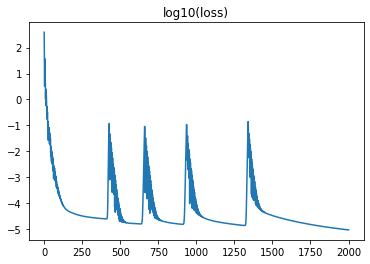

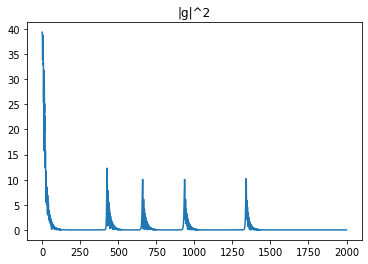

    Solving PDE2
The following Variables were used a Lambda layer's call (lambda_72), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(100, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=257.58577974048467
Epoch 50: loss=0.022088014110926254
Epoch 100: loss=0.0008707896317681598
Epoch 150: loss=0.0005982434373714804
Epoch 200: loss=0.0017570790218128692
Epoch 250: loss=0.0004708837426299398
Epoch 300: loss=0.0003013125092156322
Epoch 350: loss=0.000211043620175363
Epoch 400: loss=0.0023922524786281233
Epoch 450: loss=0.0003654102436151205
Epoch 500: loss=0.00023279568700009396
Epoch 550: loss=0.00016065773390915142
Epoch 600: loss=0.0001159925629013072
Epoch 650: loss=8.828854365444276e-05
Epoch 700: loss=0.0013440794029118196
Epoch 750: loss=0.00024490750630890246
Epoch 800: l

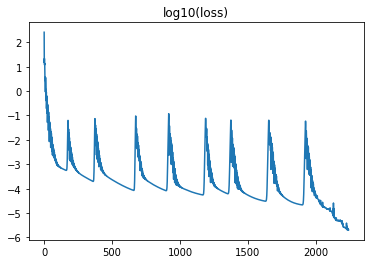

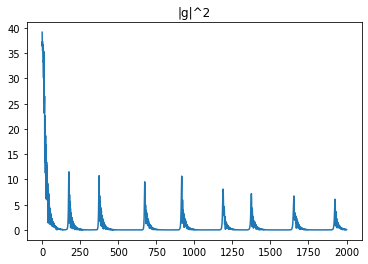

    Solving PDE3
The following Variables were used a Lambda layer's call (lambda_73), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(400, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=1955.0976774452872
Epoch 50: loss=0.02677790029313394
Epoch 100: loss=0.0855004644938645
Epoch 150: loss=0.007259824143376986
Epoch 200: loss=0.04109649986188449
Epoch 250: loss=0.05283176925407034
Epoch 300: loss=0.007339897438342383
Epoch 350: loss=0.0010102876755774754
Epoch 400: loss=0.022371937993280334
Epoch 450: loss=0.013581642822434155
Epoch 500: loss=0.0016010261848528867
Epoch 550: loss=0.007225658661362094
Epoch 600: loss=0.0501766275900421
Epoch 650: loss=0.0007642088614683786
Epoch 700: loss=0.008710135081228632
Epoch 750: loss=0.009725797129005315
Epoch 800: loss=0.00243783777216

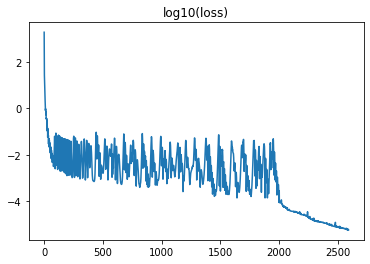

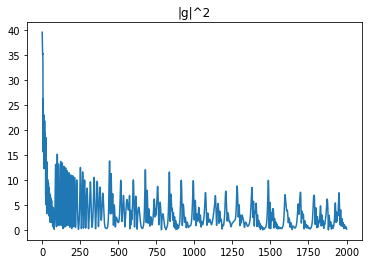

    Solving PDE4
The following Variables were used a Lambda layer's call (lambda_74), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(400, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=1754.6494065473782
Epoch 50: loss=0.08326563487870897
Epoch 100: loss=0.047884266010838984
Epoch 150: loss=0.0841710762207552
Epoch 200: loss=0.03917172292975898
Epoch 250: loss=0.01819313122372491
Epoch 300: loss=0.021384135975169024
Epoch 350: loss=0.0024174049793103916
Epoch 400: loss=0.014573333666122137
Epoch 450: loss=0.015285142164903254
Epoch 500: loss=0.008243732867121
Epoch 550: loss=0.01279152910265026
Epoch 600: loss=0.0057950464407084965
Epoch 650: loss=0.010320923724571005
Epoch 700: loss=0.015142091770979327
Epoch 750: loss=0.0018615748477959783
Epoch 800: loss=0.0126156575770733

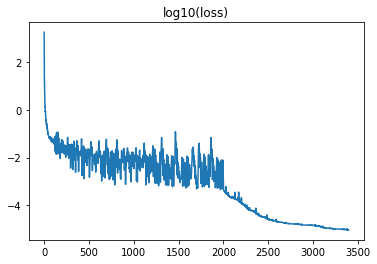

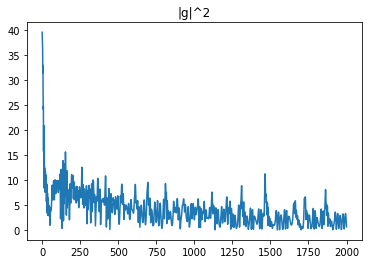

    Solving PDE5
The following Variables were used a Lambda layer's call (lambda_75), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(400, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=101090.93619032751
Epoch 50: loss=0.06940097238442876
Epoch 100: loss=0.05621476536859201
Epoch 150: loss=0.07808574452017798
Epoch 200: loss=0.006193241241624369
Epoch 250: loss=0.002449656992574812
Epoch 300: loss=0.0016371530155152567
Epoch 350: loss=0.006041436655434149
Epoch 400: loss=0.0018974423605511723
Epoch 450: loss=0.002094697431385306
Epoch 500: loss=0.005795143062205655
Epoch 550: loss=0.005442434748847936
Epoch 600: loss=0.0006204555096391545
Epoch 650: loss=0.0006022727692513562
Epoch 700: loss=0.0006427419724094349
Epoch 750: loss=0.004403424541500847
Epoch 800: loss=0.00186029

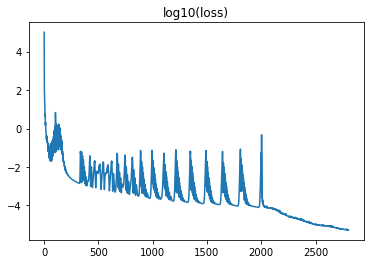

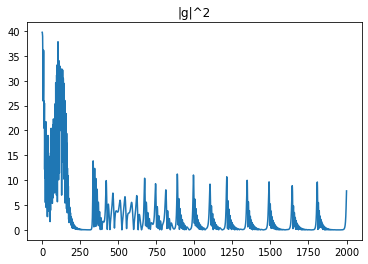

Streaming output truncated to the last 5000 lines.
Iter: 838 loss: 0.0087968546056206125
Iter: 839 loss: 0.0087647513646244169
Iter: 840 loss: 0.00872909094553126
Iter: 841 loss: 0.0089706197439950661
Iter: 842 loss: 0.0087257912029503355
Iter: 843 loss: 0.0088518589512725614
Iter: 844 loss: 0.0087066962170059443
Iter: 845 loss: 0.0087005417298750328
Iter: 846 loss: 0.00875275237722051
Iter: 847 loss: 0.0087001173436032052
Iter: 848 loss: 0.0086876901801251384
Iter: 849 loss: 0.0086797657172003329
Iter: 850 loss: 0.0086748871096869028
Iter: 851 loss: 0.008643113792928498
Iter: 852 loss: 0.0087231780383392916
Iter: 853 loss: 0.008632402552634864
Iter: 854 loss: 0.008616561335011496
Iter: 855 loss: 0.0085795342071743469
Iter: 856 loss: 0.0090119604245931656
Iter: 857 loss: 0.00857640091624113
Iter: 858 loss: 0.0085229857558669839
Iter: 859 loss: 0.0085253135962695091
Iter: 860 loss: 0.0084809033771870729
Iter: 861 loss: 0.0084307503065101149
Iter: 862 loss: 0.0085488379321225529
Iter: 86

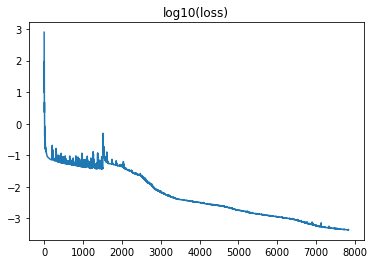

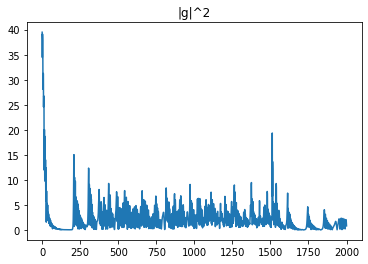

Streaming output truncated to the last 5000 lines.
Iter: 722 loss: 0.0011031754172098108
Iter: 723 loss: 0.001099536622108003
Iter: 724 loss: 0.001114124108805088
Iter: 725 loss: 0.0010987064175491672
Iter: 726 loss: 0.0011103046961884958
Iter: 727 loss: 0.0010971095245586569
Iter: 728 loss: 0.0010954498464248829
Iter: 729 loss: 0.0010911672516401246
Iter: 730 loss: 0.0011260622785681561
Iter: 731 loss: 0.0010903995047402443
Iter: 732 loss: 0.001087145791186476
Iter: 733 loss: 0.001099942133874324
Iter: 734 loss: 0.0010863895790185353
Iter: 735 loss: 0.001085380111154484
Iter: 736 loss: 0.0010910561310369326
Iter: 737 loss: 0.00108524193899259
Iter: 738 loss: 0.0010847755740620959
Iter: 739 loss: 0.00108477512531218
Iter: 740 loss: 0.0010839410509604136
Iter: 741 loss: 0.0010871640765995451
Iter: 742 loss: 0.0010837141984951476
Iter: 743 loss: 0.0010826923232865001
Iter: 744 loss: 0.0010841244037417819
Iter: 745 loss: 0.0010821860122661613
Iter: 746 loss: 0.0010812828044862095
Iter: 74

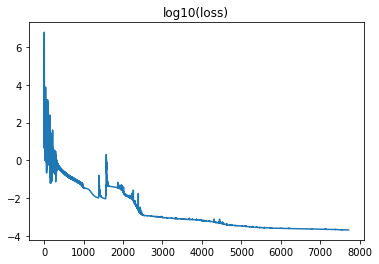

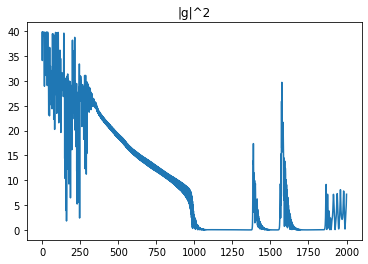

Streaming output truncated to the last 5000 lines.
Iter: 892 loss: 0.00054955812571876571
Iter: 893 loss: 0.000549215012342445
Iter: 894 loss: 0.00054778561867758818
Iter: 895 loss: 0.00054951351413743679
Iter: 896 loss: 0.00054709147288362655
Iter: 897 loss: 0.00054296900181026138
Iter: 898 loss: 0.00053305219136862169
Iter: 899 loss: 0.00065431396304835982
Iter: 900 loss: 0.0005320928166162686
Iter: 901 loss: 0.00052886015383731119
Iter: 902 loss: 0.00052624842508876366
Iter: 903 loss: 0.00052402864556666735
Iter: 904 loss: 0.00053225101372606431
Iter: 905 loss: 0.00052348601689853887
Iter: 906 loss: 0.00052119056382472816
Iter: 907 loss: 0.00051563130262159717
Iter: 908 loss: 0.00066723148948913055
Iter: 909 loss: 0.00051534994269293827
Iter: 910 loss: 0.00051151698751166939
Iter: 911 loss: 0.00055001829405383347
Iter: 912 loss: 0.00051142595853637292
Iter: 913 loss: 0.00051125981006957394
Iter: 914 loss: 0.0005102601388645735
Iter: 915 loss: 0.000509102394944028
Iter: 916 loss: 0.0

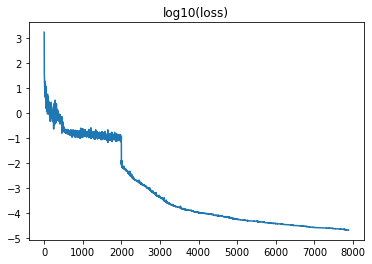

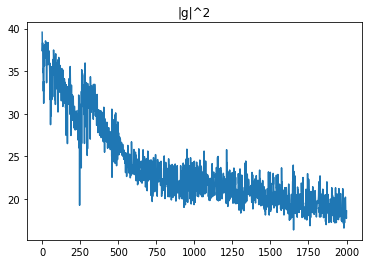

    Solving PDE9
The following Variables were used a Lambda layer's call (lambda_79), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(100, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=1421549.16220165
Epoch 50: loss=0.06886657666177898
Epoch 100: loss=0.03635917891869322
Epoch 150: loss=0.02536038801397143
Epoch 200: loss=0.015886287155124794
Epoch 250: loss=0.008690542802758997
Epoch 300: loss=0.008970001920429415
Epoch 350: loss=0.003811938996512833
Epoch 400: loss=0.003414465338789225
Epoch 450: loss=0.03970593772276483
Epoch 500: loss=0.0019382583981568922
Epoch 550: loss=0.0015343771136694486
Epoch 600: loss=0.005946163552946987
Epoch 650: loss=0.0012029132510577767
Epoch 700: loss=0.0009555953338066868
Epoch 750: loss=0.0008285104783105001
Epoch 800: loss=0.00073280100

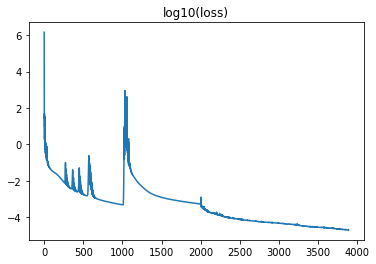

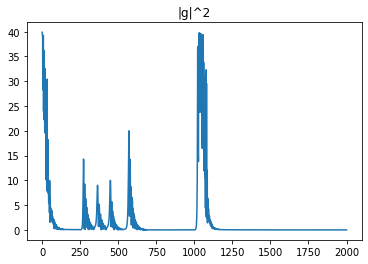

Streaming output truncated to the last 5000 lines.
Iter: 1434 loss: 0.0022469565103907037
Iter: 1435 loss: 0.0022538532679730297
Iter: 1436 loss: 0.0022464752349449944
Iter: 1437 loss: 0.0022459835373550441
Iter: 1438 loss: 0.0022456471494901337
Iter: 1439 loss: 0.0022452399454240416
Iter: 1440 loss: 0.0022506516323471957
Iter: 1441 loss: 0.0022452378044758824
Iter: 1442 loss: 0.0022450096215485076
Iter: 1443 loss: 0.002247946973057469
Iter: 1444 loss: 0.0022450079262977068
Iter: 1445 loss: 0.002244795472864367
Iter: 1446 loss: 0.00224428475754543
Iter: 1447 loss: 0.0022498316548469005
Iter: 1448 loss: 0.0022442317056789152
Iter: 1449 loss: 0.0022437459936533706
Iter: 1450 loss: 0.0022450454729085892
Iter: 1451 loss: 0.002243584253479548
Iter: 1452 loss: 0.0022429775229137559
Iter: 1453 loss: 0.0022442792194453131
Iter: 1454 loss: 0.0022427407613788233
Iter: 1455 loss: 0.0022423242957089135
Iter: 1456 loss: 0.0022422942618293448
Iter: 1457 loss: 0.0022420445812036532
Iter: 1458 loss: 0

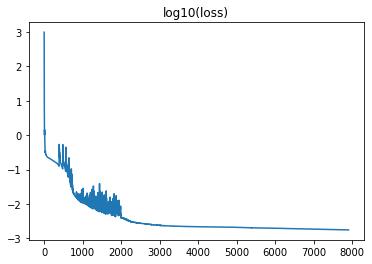

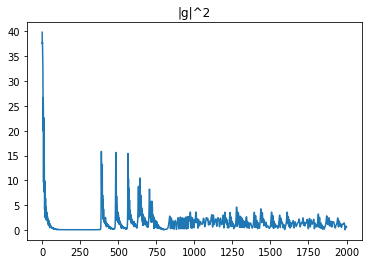

In [ ]:
default_kwargs={
    "N_f": 1000,
    "epochs": 2000,
    "clip_grad": 1,
    "learning_rate": 0.01,
    "model_builder": rnn_builder,
    "optimizers": [1, 1],
}

test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
def first_order_equation_builder_builder_plus(equation, plus):
    def equation_builder(model, ixv):
        @tf.function
        def equation_function(ixv):
            with tf.GradientTape() as g:
                y_pred_inside = model(ixv) + plus(ixv)
            dy_dx_inside = g.batch_jacobian(y_pred_inside, ixv)
            return equation(ixv, y_pred_inside, dy_dx_inside)
        return equation_function
    return equation_builder


def second_order_equation_builder_builder_plus(equation, plus):
    def equation_builder(model, ixv):
        @tf.function
        def equation_function(ixv):
            with tf.GradientTape() as g:
                with tf.GradientTape() as g2:
                    y_pred_inside = model(ixv) + plus(ixv)
                dy_dx_inside = g2.batch_jacobian(y_pred_inside, ixv)
            dy_dx2_inside = g.batch_jacobian(dy_dx_inside, ixv)
            return equation(ixv, y_pred_inside, dy_dx_inside, dy_dx2_inside)
        return equation_function
    return equation_builder

def sode1_plus(x):
    return tf.transpose(tf.squeeze(tf.stack([
        tf.zeros(x.shape, dtype=tf.dtypes.float64),
        10*tf.exp(-x)])))

experiments = [{
    "ode": "L-ODE1",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.ones(x.shape).reshape((-1,1)),
}, {
    "ode": "L-ODE2",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]-y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(x).reshape((-1,1)),
}, {
    "ode": "L-ODE3",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]+3*y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(-3 * x).reshape((-1,1)),
}, {
    "ode": "L-ODE4",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]-10*y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(10 * x).reshape((-1,1)),
}, {
    "ode": "L-ODE5",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([[1.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]+15*y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.exp(-15 * x).reshape((-1,1)),
}, {
    "ode": "L-ODEn2",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([1., 0.]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder_plus(
        equation=lambda x, y, dy, d2y: d2y[:,0,0,0]+1001*dy[:,0,0]+1000*y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: 1000/999 * np.exp(-x)-1/999*np.exp(-1000*x),
}, {
    "ode": "L-ODEn3",
    "border_xs": np.array([[0.], [1.]]),
    "border_ys": np.array([[0.], [np.sin(1) / np.exp(0.2)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder_plus(
        equation=lambda x, y, dy, d2y: d2y[:,0,0,0] + dy[:,0,0] / 5. + y[:,0] + tf.exp(-x[:,0] / 5.) * tf.cos(x[:,0]) / 5.,
        plus=lambda x: tf.reshape(x*np.sin(1)/np.exp(0.2), (-1, 1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (np.exp(-x/5)*np.sin(x)).reshape((-1, 1)),
}, {
    "ode": "NL-ODE1",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0] + (y[:,0] - 2 * x[:,0]) / x[:,0],
        plus=lambda x: tf.reshape(20.1*tf.exp(-(x-0.1)), (-1,1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
}, {
    "ode": "NL-ODE2",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0] * x[:,0] + y[:,0] - 2 * x[:,0],
        plus=lambda x: tf.reshape(20.1*tf.exp(-(x-0.1)), (-1,1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
}, {
    "ode": "NL-ODE3",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]+(y[:,0]*tf.cos(x[:,0])-1)/tf.sin(x[:,0]),
        plus=lambda x: tf.reshape(2.1/np.sin(0.1)*tf.exp(-(x-0.1)), (-1,1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x),
}, {
    "ode": "NL-ODE4",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]*tf.sin(x[:,0])+y[:,0]*tf.cos(x[:,0])-1,
        plus=lambda x: tf.reshape(2.1/np.sin(0.1)*tf.exp(-(x-0.1)), (-1,1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x),
}, {
    "ode": "NL-ODEn1",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[1.], [0.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder_plus(
        equation=lambda x, y, dy, dy2: 4*tf.pow(x[:,0], 2)*dy2[:,0,0,0]+y[:,0],
        plus=lambda x: np.ones(x.shape)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: -(1/2)*np.sqrt(x)*(np.log(x)-2).reshape((-1, 1)),
}, {
    "ode": "NL-ODEn2",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[0.], [3.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder_plus(
        equation=lambda x, y, dy, dy2: tf.pow(x[:,0], 2)*dy2[:,0,0,0]+x[:,0]*dy[:,0,0]+y[:,0]-5*tf.pow(x[:,0],2),
        plus=lambda x: tf.reshape(tf.sin(3*(x-1)), (-1,1))),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.power(x,2)+np.sin(np.log(x))-np.cos(np.log(x)),
}, {
    "ode": "SODE1",
    "border_xs": np.array([[0.]]),
    "border_ys": np.array([0., 10.]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(equation=lambda x, y, dy: tf.stack([
        dy[:,1,0] + 100 * y[:,0],
        y[:,1] - dy[:,0,0]
    ]), plus=sode1_plus),
    "input_dim": 1,
    "output_dim": 2,
    "sol": lambda x: np.hstack([
        10*np.cos(10*x),
        np.sin(10*x)]),
}, {
    "ode": "SODE2",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[0, 1, 1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [np.pi]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] - y[:,1] * y[:,2],
        dy[:,1,0] + y[:,0] * y[:,2],
        dy[:,2,0] + 0.5 * y[:,0] * y[:,1]
    ]), plus=lambda x: np.hstack([
        np.zeros(x.shape),
        np.ones(x.shape),
        np.ones(x.shape)])),
    "input_dim": 1,
    "output_dim": 3,
    "sol": lambda x: np.array(ellipj(x, 0.5))[:3,:,0].T,
}, {
    "ode": "SODE3",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[1, 0, 0]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [40]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] + 0.04 * y[:,0] - 1e4 * y[:,1] * y[:,2],
        dy[:,1,0] - 0.04 * y[:,0] + 1e4 * y[:,1] * y[:,2] + 3e7 * tf.pow(y[:,1], 2),
        dy[:,2,0] - 3e7 * tf.pow(y[:,1], 2)
    ]), plus=lambda x: np.hstack([
        np.ones(x.shape),
        np.zeros(x.shape),
        np.zeros(x.shape)])),
    "input_dim": 1,
    "output_dim": 3,
    "error_f": lambda x,y,z:-1,
}, {
    "ode": "PDE1",
    "border_xs": pde1_border_xs,
    "border_ys": (lambda x: x[:,0] * np.exp(-np.power(x[:,0],2)))(pde1_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: dy[:,0,0]+3*dy[:,0,1],
        plus=lambda x: tf.reshape(x[:,0]*tf.exp(-tf.pow(x[:,0],2)), (-1,1))),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: ((x[:,1]-3*x[:,0])*np.exp(-np.power(x[:,1]-3*x[:,0],2))).reshape((-1, 1)),
}, {
    "ode": "PDE2",
    "border_xs": pde1_border_xs,
    "border_ys": (lambda x:np.sin(2*np.pi*x[:,0]))(pde1_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder_plus(
        equation=lambda x, y, dy: 5*dy[:,0,0]+dy[:,0,1]-x[:,0],
        plus=lambda x: tf.reshape(tf.sin(2*np.pi*x[:,0]), (-1,1))),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: ((1/5)*x[:,0]*x[:,1]-(1/50)*np.power(x[:,0],2)+np.sin(2*np.pi/5*(5*x[:,1]-x[:,0]))).reshape((-1, 1)),
}, {
    "ode": "PDE6",
    "border_xs": border3_xs,
    "border_ys": border3_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, -1], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder_plus(
        equation=lambda x, y, dy, dy2: 0.01/np.pi*dy2[:,0,1,1]-dy[:,0,0]-y[:,0]*dy[:,0,1],
        plus=lambda x: -tf.reshape(tf.sin(np.pi*x[:,0]), (-1,1))),
    "input_dim": 2,
    "output_dim": 1,
    "error_f": error_stored("burgers_shock.mat"),
}]
# experiments=experiments[1:][:1]
print(experiments[0]["ode"], experiments[-1]["ode"])

L-ODE2 L-ODE2


In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     "optimizers": [1, 1],
# }

# test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
experiments = [{
    "ode": "NL-ODE1",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0] + (y[:,0] - 2 * x[:,0]) / x[:,0]),    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
    "x_min": 0.1,
}, {
    "ode": "NL-ODE2",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[20.1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0] * x[:,0] + y[:,0] - 2 * x[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: x+2/x,
    "x_min": 0.1,
}, {
    "ode": "NL-ODE3",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]+(y[:,0]*tf.cos(x[:,0])-1)/tf.sin(x[:,0])),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x),
    "x_min": 0.1,
}, {
    "ode": "NL-ODE4",
    "border_xs": np.array([[0.1]]),
    "border_ys": np.array([[2.1/np.sin(0.1)]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,0]*tf.sin(x[:,0])+y[:,0]*tf.cos(x[:,0])-1),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: (x+2)/np.sin(x),
    "x_min": 0.1,
}, {
    "ode": "NL-ODEn1",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[1.], [0.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: 4*tf.pow(x[:,0], 2)*dy2[:,0,0,0]+y[:,0]),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: -(1/2)*np.sqrt(x)*(np.log(x)-2).reshape((-1, 1)),
    "x_min": 0.1,
}, {
    "ode": "NL-ODEn2",
    "border_xs": np.array([[1.]]),
    "border_ys": np.array([[0.], [3.]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0.1], [1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: tf.pow(x[:,0], 2)*dy2[:,0,0,0]+x[:,0]*dy[:,0,0]+y[:,0]-5*tf.pow(x[:,0],2)),
    "input_dim": 1,
    "output_dim": 1,
    "sol": lambda x: np.power(x,2)+np.sin(np.log(x))-np.cos(np.log(x)),
    "x_min": 0.1,
}, {
    "ode": "SODE2",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[0, 1, 1]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [np.pi]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] - y[:,1] * y[:,2],
        dy[:,1,0] + y[:,0] * y[:,2],
        dy[:,2,0] + 0.5 * y[:,0] * y[:,1]
    ])),
    "input_dim": 1,
    "output_dim": 3,
    "sol": lambda x: np.array(ellipj(x, 0.5))[:3,:,0].T,
    "x_max": np.pi
}, {
    "ode": "SODE3",
    "border_xs": np.array([[0]]),
    "border_ys": np.array([[1, 0, 0]]),
    "inside_xs_builder": linspace_inside_xs_builder_builder([0], [40]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x,y,dy:tf.stack([
        dy[:,0,0] + 0.04 * y[:,0] - 1e4 * y[:,1] * y[:,2],
        dy[:,1,0] - 0.04 * y[:,0] + 1e4 * y[:,1] * y[:,2] + 3e7 * tf.pow(y[:,1], 2),
        dy[:,2,0] - 3e7 * tf.pow(y[:,1], 2)
    ])),
    "input_dim": 1,
    "output_dim": 3,
    "error_f": lambda x,y,z:-1,
    "x_max": 40
}, {
    "ode": "PDE5",
    "border_xs": border4_xs,
    "border_ys": border4_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([-1, -1], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, dy2: dy2[:,0,0,0]+dy2[:,0,1,1]+tf.exp(y[:,0])-1-x[:,0]**2-x[:,1]**2-4/((1+x[:,0]**2+x[:,1]**2)**2)),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: (np.log(1+np.power(x[:,0],2)+np.power(x[:,1],2))).reshape((-1, 1)),
    "x_min": -1
}, {
    "ode": "PDE6",
    "border_xs": border3_xs,
    "border_ys": border3_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, -1], [1, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x, y, dy, dy2: 0.01/np.pi*dy2[:,0,1,1]-dy[:,0,0]-y[:,0]*dy[:,0,1]),
    "input_dim": 2,
    "output_dim": 1,
    "error_f": error_stored("burgers_shock.mat"),
    "x_min": np.array([0, -1])
}, {
    "ode": "PDE7",
    "border_xs": border6_xs,
    "border_ys": border6_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 1], [-1, 1]),
    "border_builder": allencahn_border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x,y,dy,dy2:dy[:,0,0]-0.0001*dy2[:,0,1,1]+5*tf.pow(y[:,0],3)-5*y[:,0]),
    "input_dim": 2,
    "output_dim": 1,
    "error_f": error_stored("AC.mat"),
    "x_min": np.array([0, 1]),
    "x_max": np.array([-1, 1])
}, {
    "ode": "PDE9",
    "border_xs": border5_xs,
    "border_ys": border5_ys,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, np.pi/2], [-5, 5]),
    "border_builder": schrodinger_border_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x,y,dy,dy2:tf.stack([
        -dy[:,1,0] + 0.5 * dy2[:,0,1,1] + tf.pow(tf.norm(y, axis=1), 2) * y[:,0],
        dy[:,0,0] + 0.5 * dy2[:,1,1,1] + tf.pow(tf.norm(y, axis=1), 2) * y[:,1]
    ])),
    "input_dim": 2,
    "output_dim": 2,
    "error_f": error_schrodinger_stored("NLS.mat"),
    "x_min": np.array([0, -5]),
    "x_max": np.array([np.pi/2, 5])
}, {
    "ode": "PDE10",
    "border_xs": pde10_border_xs,
    "border_ys": pde10_sol(pde10_border_xs),
    "inside_xs_builder": linspace_inside_xs_builder_builder([-0.5, -0.5], [1, 1.5]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": second_order_equation_builder_builder(equation=lambda x,y,dy,dy2:tf.stack([
        -0.025*(dy2[:,0,0,0]+dy2[:,0,1,1])+y[:,0]*dy[:,0,0]+y[:,1]*dy[:,0,1]+dy[:,2,0],
        -0.025*(dy2[:,0,0,0]+dy2[:,0,1,1])+y[:,0]*dy[:,1,0]+y[:,1]*dy[:,1,1]+dy[:,2,1],
        dy[:,0,0]+dy[:,1,1]
    ])),
    "input_dim": 2,
    "output_dim": 3,
    "sol": pde10_sol,
    "x_min": np.array([-0.5, -0.5]),
    "x_max": np.array([1, 1.5]),
}]
experiments=experiments[9:]#[:1]
print(experiments[0]["ode"], experiments[-1]["ode"])

PDE6 PDE10


In [ ]:
# default_kwargs={
#     "N_f": 1000,
#     "epochs": 2000,
#     "clip_grad": 1,
#     "learning_rate": 0.01,
#     "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
#     "optimizers": [1, 1],
# }

# test_parameter("border_loss_multiplier", [1], default_kwargs)

In [ ]:
N_b = 100

experiments = [{
    "ode": "L-ODE1",
    "border_xs": np.vstack([np.linspace(-2, 2, N_b), np.zeros((N_b,))]).T,
    "border_ys": np.ones(N_b).reshape((-1, 1)),
    "inside_xs_builder": linspace_inside_xs_builder_builder([-10, 1], [10, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(
        equation=lambda x, y, dy: dy[:,0,1] - x[:,0] * y[:,0]),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: np.exp(x[:,0] * x[:,1]).reshape((-1, 1))
}, {
    "ode": "L-ODEn1",
    "border_xs": np.vstack([np.linspace(0, 10, N_b), np.zeros((N_b,))]).T,
    "border_ys": np.vstack([np.zeros((N_b,)), np.linspace(0, 10, N_b)]).T,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [10, 1]),
    "border_builder": border_builder,
    "equation_builder": second_order_equation_builder_builder(
        equation=lambda x, y, dy, d2y: d2y[:,0,1,1] + x[:,0] * y[:,0]),
    "input_dim": 2,
    "output_dim": 1,
    "sol": lambda x: np.sin(x[:,0] * x[:,1]).reshape((-1, 1))
}, {
    "ode": "SODE1",
    "border_xs": np.vstack([np.linspace(0, 10, N_b), np.zeros((N_b,))]).T,
    "border_ys": np.vstack([np.zeros((N_b,)), np.linspace(0, 10, N_b)]).T,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [10, 1]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x, y, dy: tf.stack([
        dy[:,1,1] + x[:,0] * y[:,0],
        y[:,1] - dy[:,0,1]
    ])),
    "input_dim": 2,
    "output_dim": 2,
    "sol": lambda x: np.hstack([
        x[:,0]*np.cos(x[:,0]*x[:,1]),
        np.sin(x[:,0]*x[:,1])])
}, {
    "ode": "SODE2",
    "border_xs": np.vstack([np.linspace(0, 1, N_b), np.zeros((N_b,))]).T,
    "border_ys": np.vstack([np.zeros((N_b,)), np.ones((N_b,)), np.ones((N_b,))]).T,
    "inside_xs_builder": linspace_inside_xs_builder_builder([0, 0], [1, np.pi]),
    "border_builder": border_with_function_values_builder,
    "equation_builder": first_order_equation_builder_builder(equation=lambda x,y,dy:tf.stack([
        dy[:,0,1] - y[:,1] * y[:,2],
        dy[:,1,1] + y[:,0] * y[:,2],
        dy[:,2,1] + x[:,0] * y[:,0] * y[:,1]
    ])),
    "input_dim": 2,
    "output_dim": 3,
    "sol": lambda x: np.array(ellipj(x[:,1], x[:,0]))[:3,:,0].T
}]
experiments=experiments[:1]#[:1]
print(experiments[0]["ode"], experiments[-1]["ode"])

L-ODE1 L-ODE1








Testing border_loss_multiplier=1
    Solving L-ODE1
The following Variables were used a Lambda layer's call (lambda_19), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(100, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Epoch 0: loss=7.459404212704506


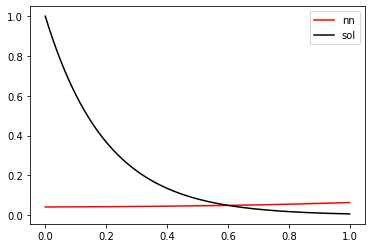

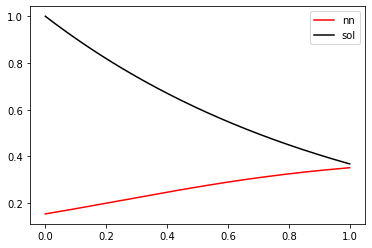

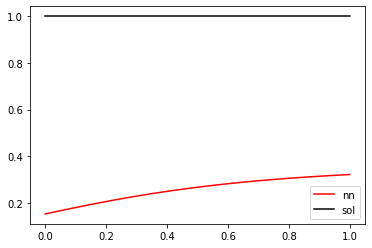

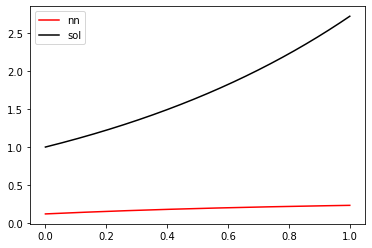

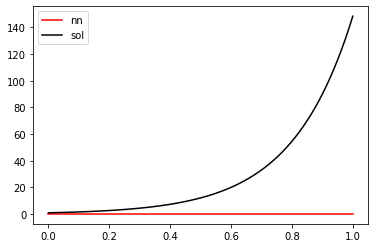

Epoch 50: loss=0.052193504905483724
Epoch 100: loss=0.005453225575877699


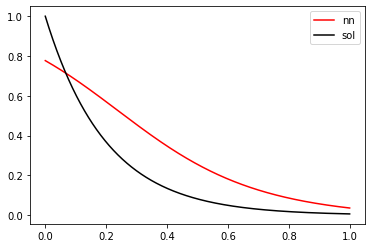

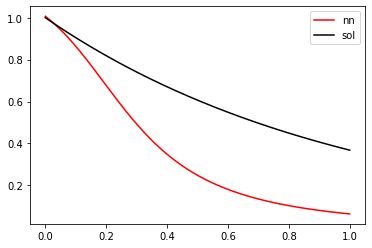

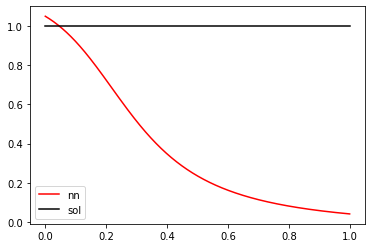

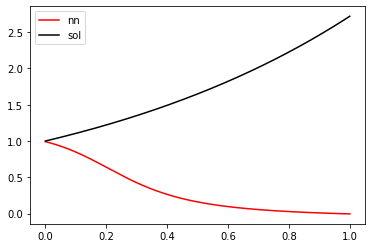

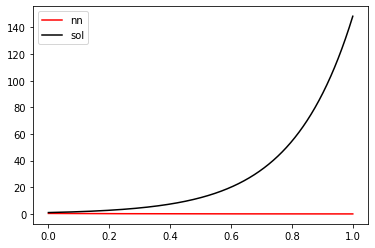

Epoch 150: loss=0.0019548344002381264
Epoch 200: loss=0.0009801696771133076


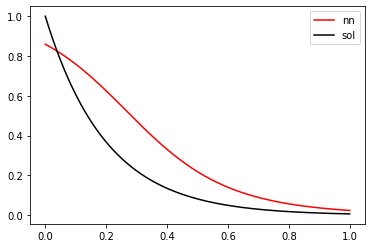

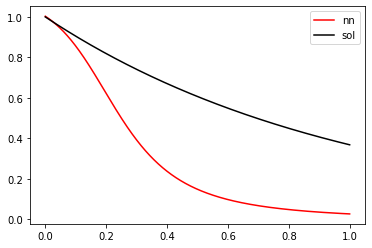

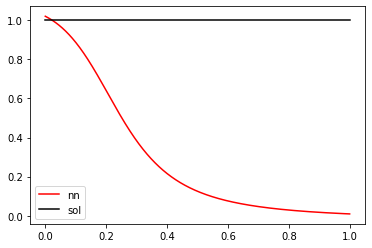

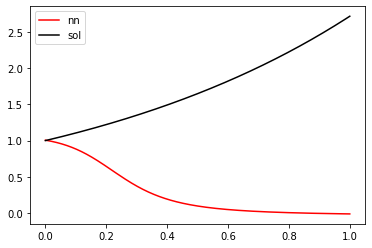

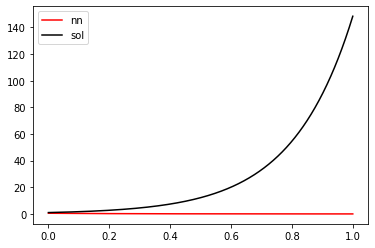

Epoch 250: loss=0.0005593037172349378
Epoch 300: loss=0.034547858404358645


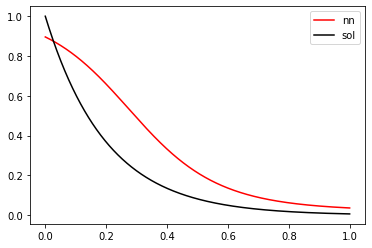

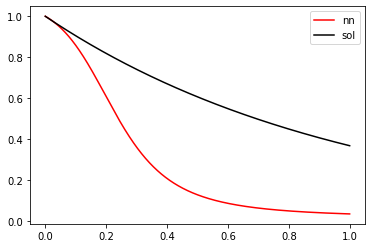

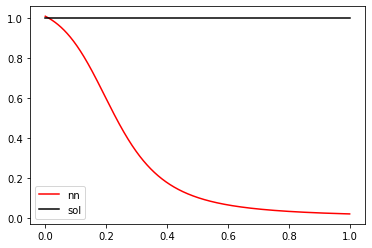

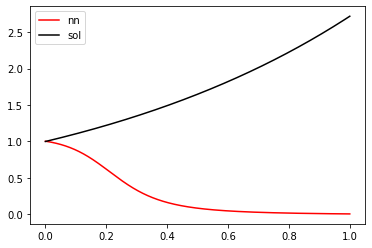

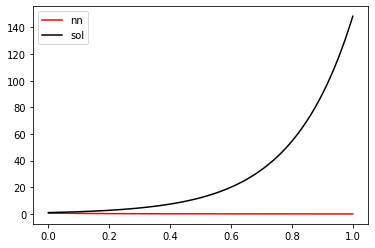

Epoch 350: loss=0.00027411357270657236
Epoch 400: loss=0.0001700926346192064


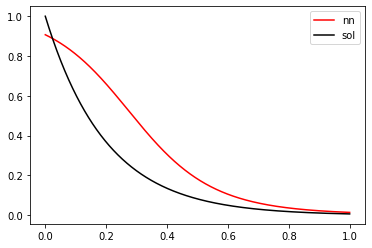

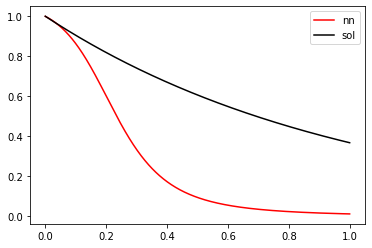

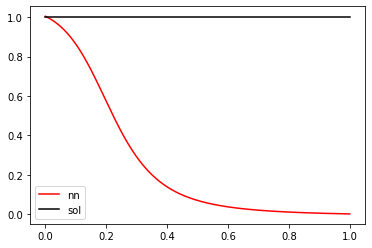

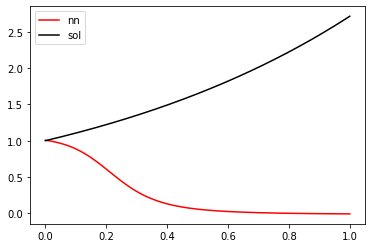

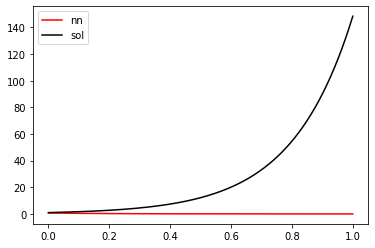

Epoch 450: loss=0.00012099951879006798
Epoch 500: loss=0.0011113774259249325


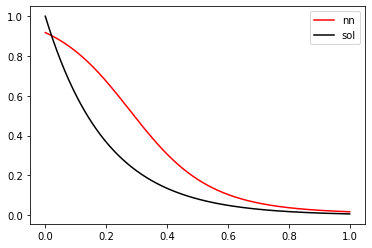

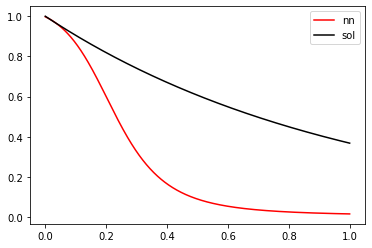

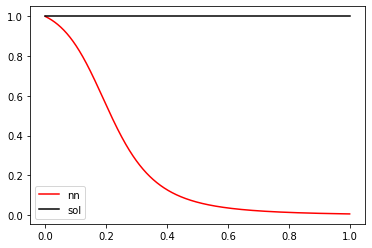

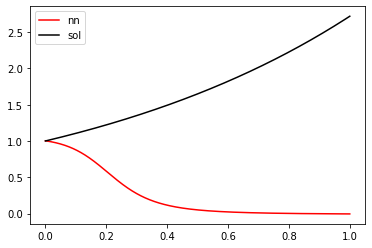

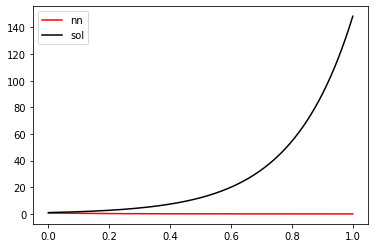

Epoch 550: loss=8.828659421918905e-05
Epoch 600: loss=6.645315429579528e-05


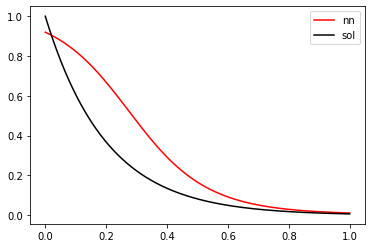

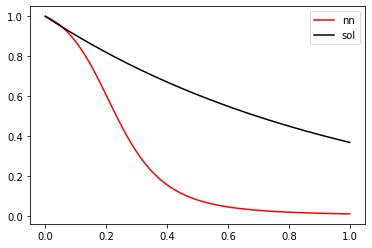

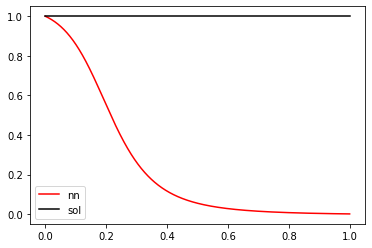

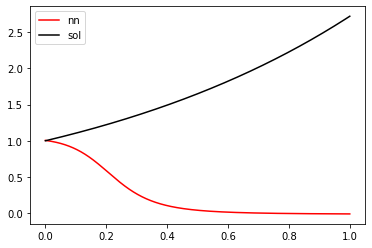

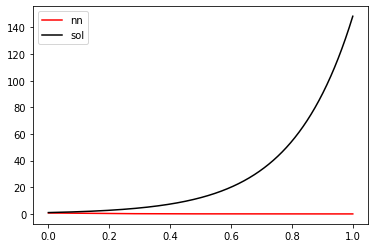

Epoch 650: loss=5.1827894901584806e-05
Epoch 700: loss=0.0006299511271434667


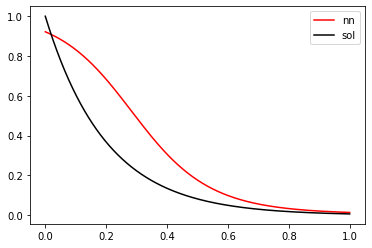

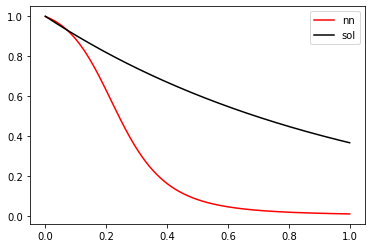

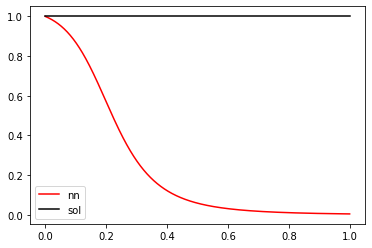

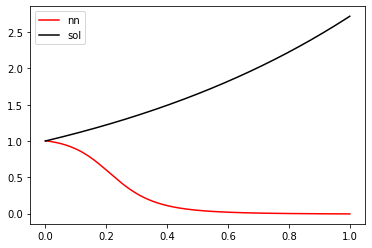

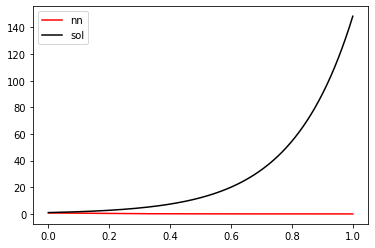

Epoch 750: loss=5.997139577634431e-05
Epoch 800: loss=3.816599253183381e-05


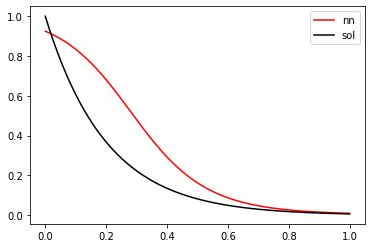

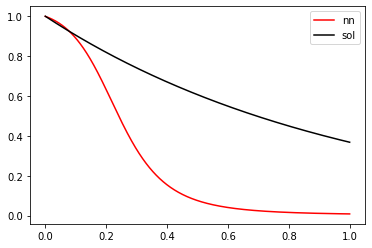

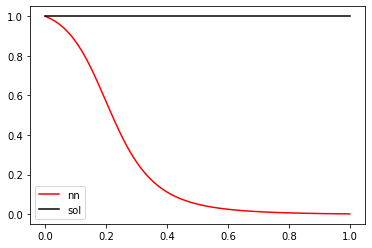

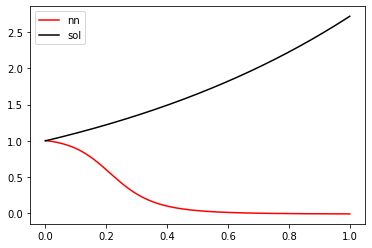

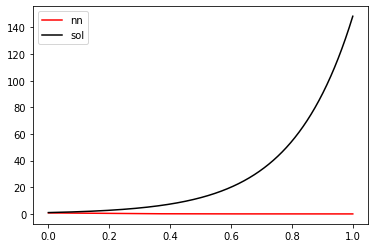

Epoch 850: loss=3.100604529078393e-05
Epoch 900: loss=2.6127274838234408e-05


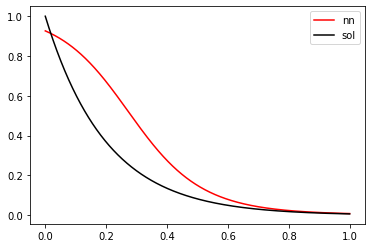

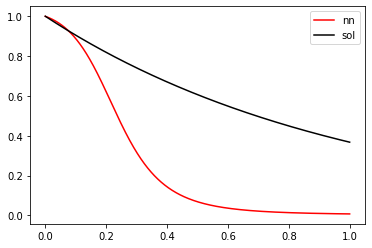

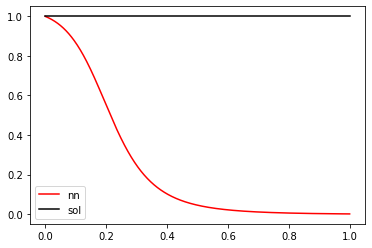

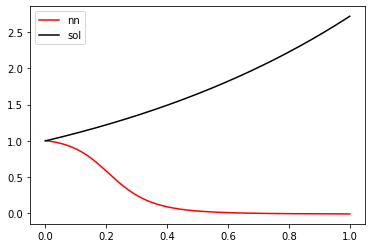

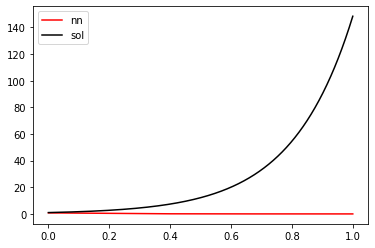

Epoch 950: loss=6.549737756657117e-05
Epoch 1000: loss=3.1645248805898863e-05


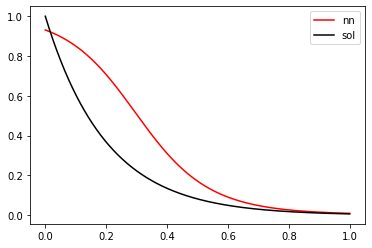

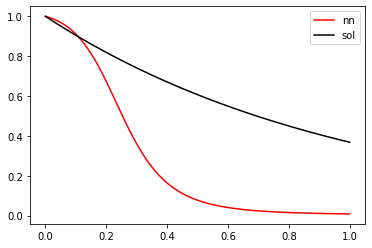

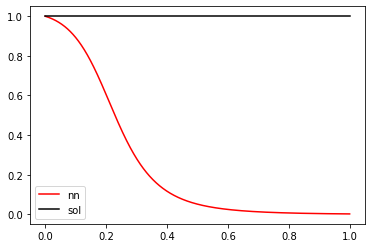

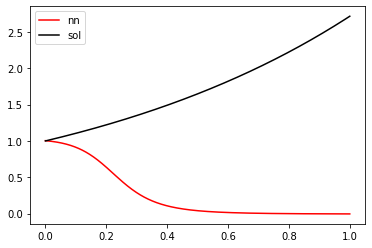

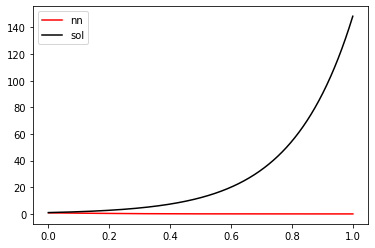

Epoch 1050: loss=2.275942540091866e-05
Epoch 1100: loss=1.8830070694854817e-05


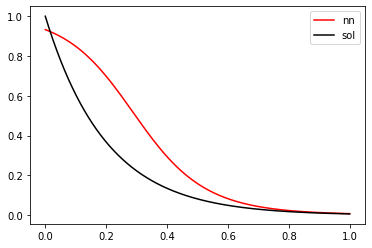

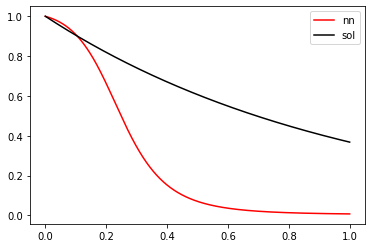

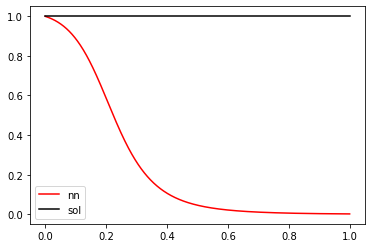

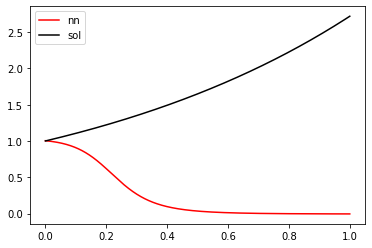

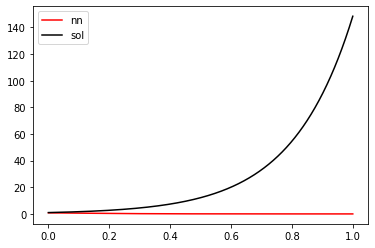

Epoch 1150: loss=1.5987893366804647e-05
Epoch 1200: loss=0.002740907983802615


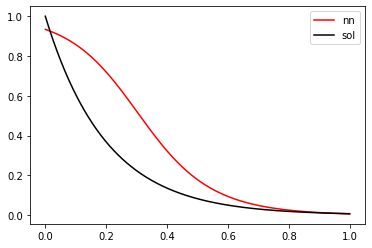

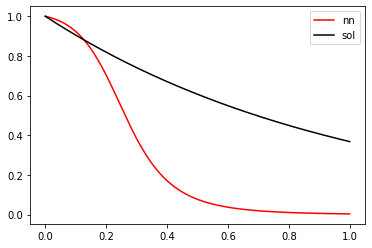

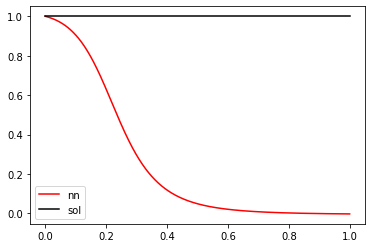

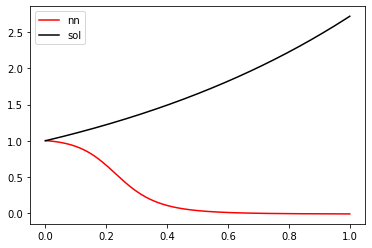

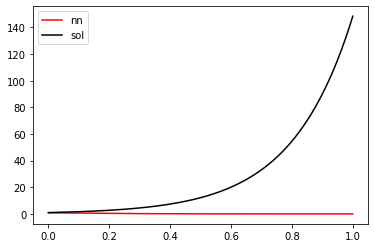

Epoch 1250: loss=2.358444855908685e-05
Epoch 1300: loss=1.6171740811209467e-05


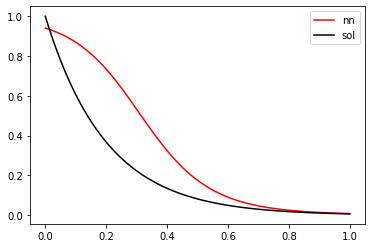

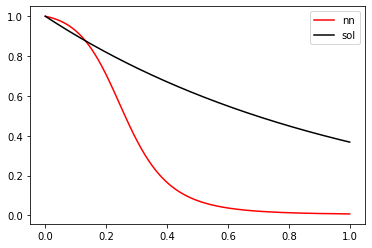

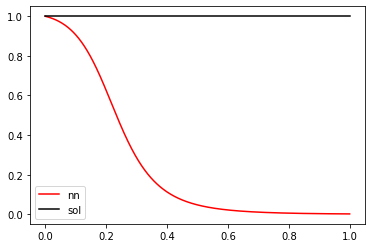

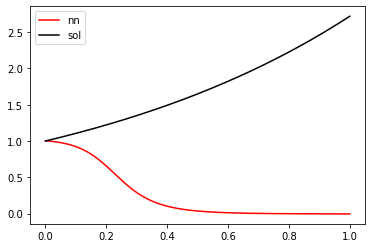

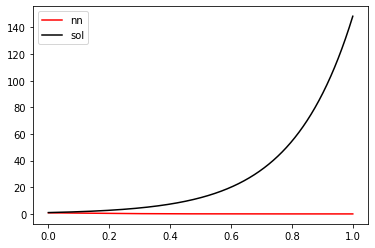

Epoch 1350: loss=1.3217594496715306e-05
Epoch 1400: loss=1.1231379431996068e-05


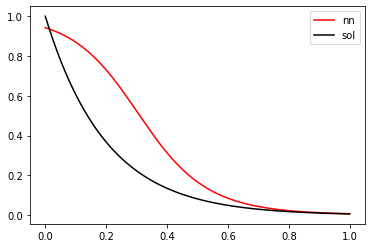

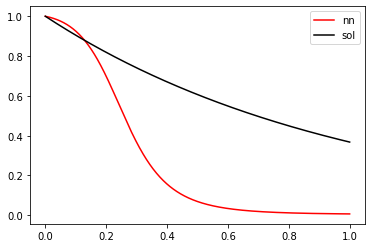

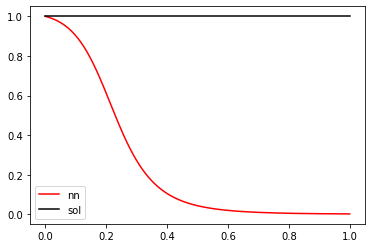

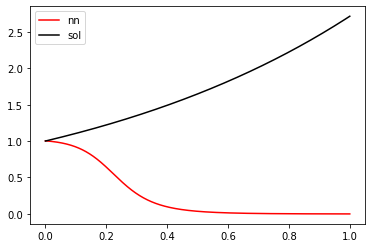

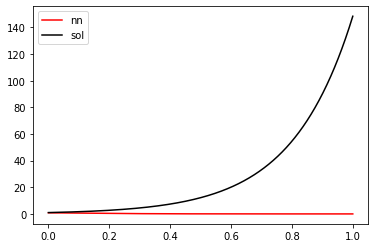

Epoch 1450: loss=9.796541856960704e-06
Epoch 1500: loss=0.00021322562410085495


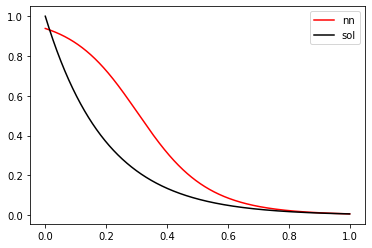

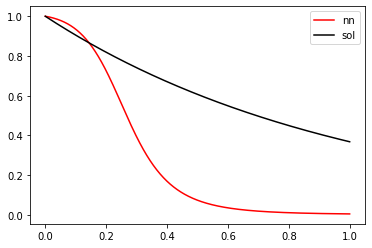

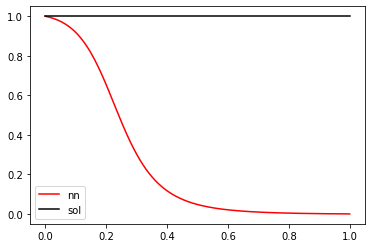

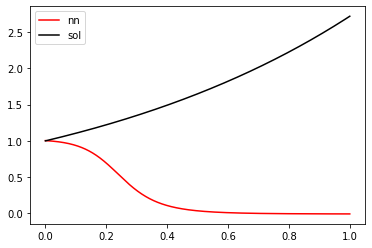

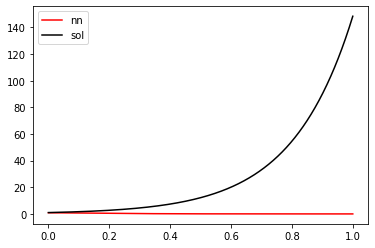

Epoch 1550: loss=1.9632287698438794e-05
Epoch 1600: loss=1.0436453980502702e-05


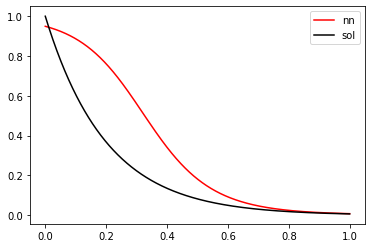

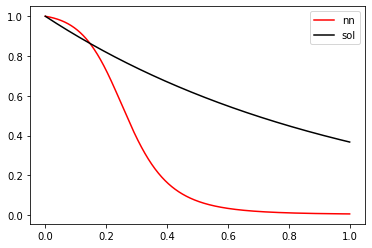

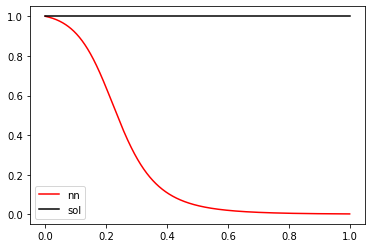

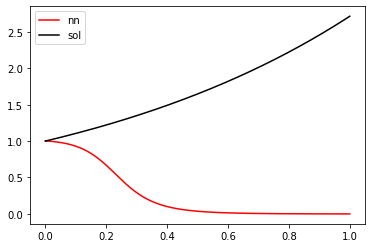

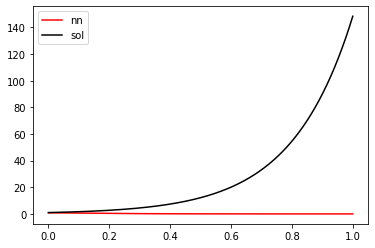

Epoch 1650: loss=8.720824419367244e-06
Epoch 1700: loss=7.539630233229275e-06


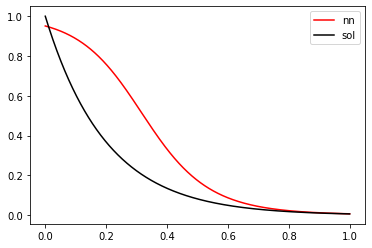

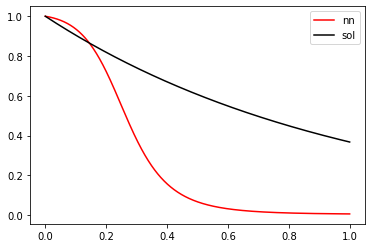

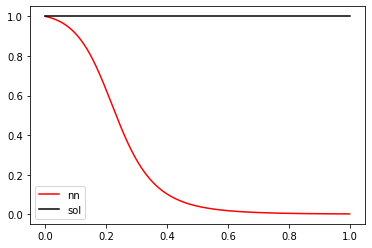

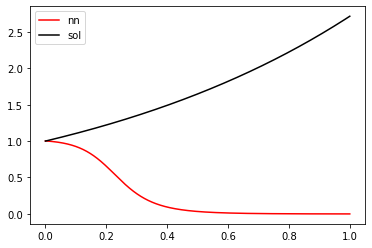

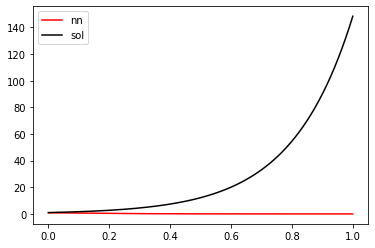

Epoch 1750: loss=6.69497295092756e-06
Epoch 1800: loss=0.0007383275343887208


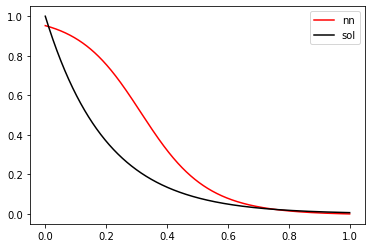

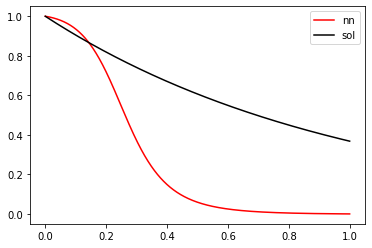

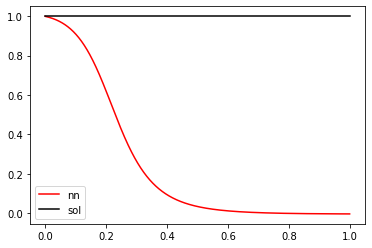

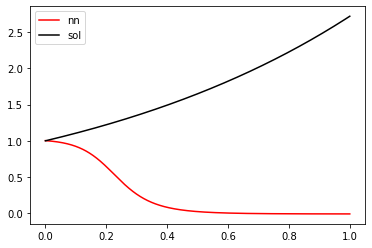

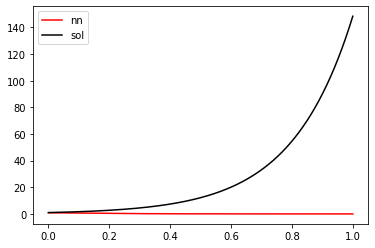

Epoch 1850: loss=3.800775376069017e-05
Epoch 1900: loss=8.407884061580555e-06


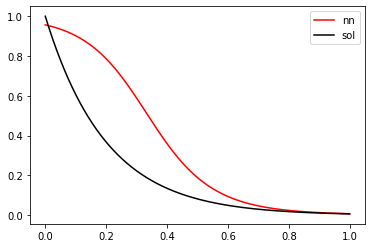

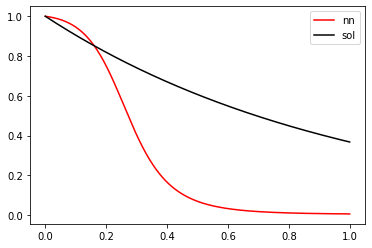

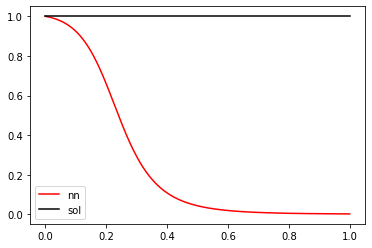

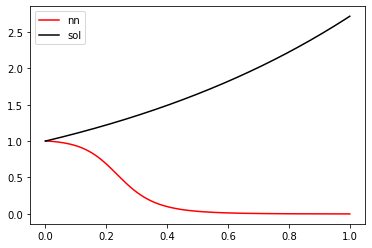

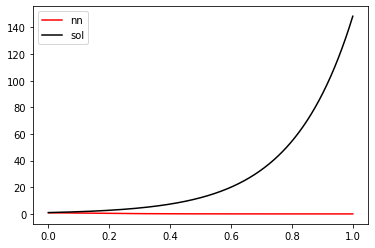

Epoch 1950: loss=6.640721618098044e-06
Epoch 2000: loss=5.694313524716369e-06


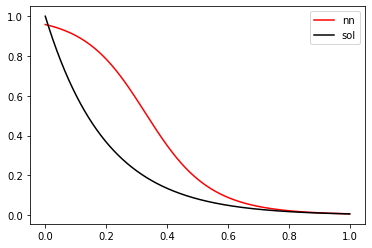

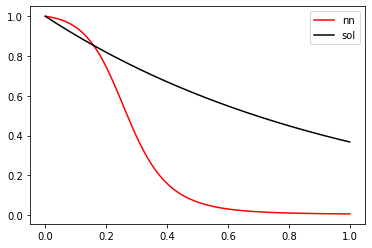

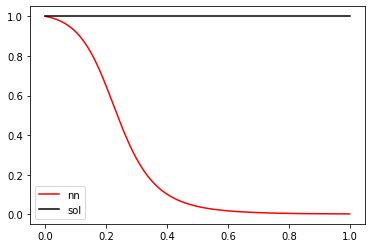

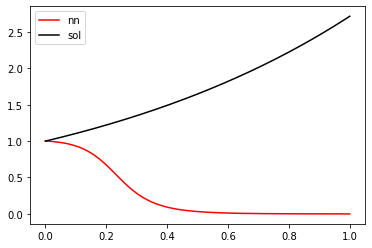

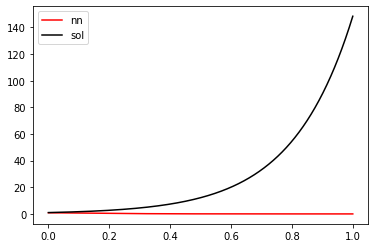

Iter: 1 loss: 5.6789482197624445e-06
best


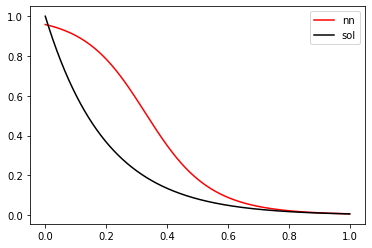

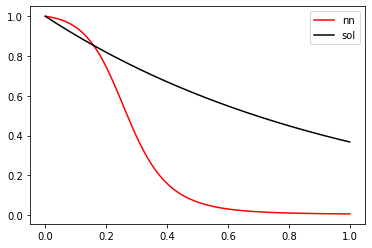

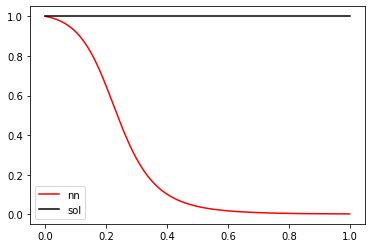

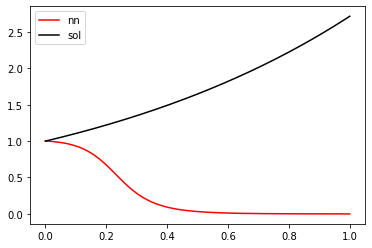

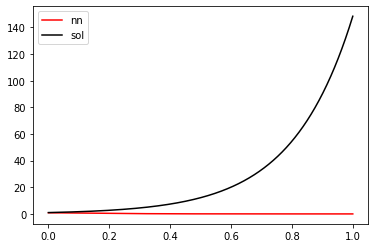

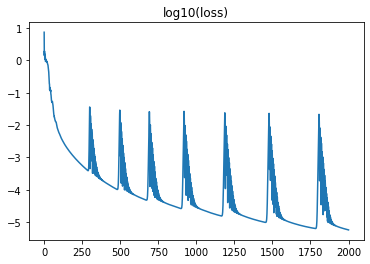

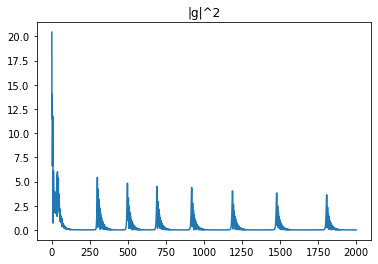

In [ ]:
def param_plot_builder(sol, params, min_x=0, max_x=1, points=1000):
    def plot(model):
        for param in params:
            xs = np.vstack([np.ones((points,))*param, np.linspace(min_x, max_x, points)]).T
            ys = model(xs)[:,0]
            plt.plot(xs[:,1], ys, c='r', label="nn")
            plt.plot(xs[:,1], sol(xs).reshape((-1,)), c='k', label="sol")
            plt.legend()
            plt.show()
    return plot

default_kwargs={
    "N_f": 1000,
    "epochs": 2000,
    "clip_grad": 1,
    "learning_rate": 0.01,
    "model_builder": simple_nn_builder_builder([10, 10, 10, 10, 10, 10, 10]),
    "optimizers": [1, 1],
    "N_f": 10000,
    "plot_callback": param_plot_builder(experiments[0]["sol"], [-5, -1, 0, 1, 5])
}

test_parameter("border_loss_multiplier", [1], default_kwargs)

# Hyperparameter tests

In [ ]:
default_kwargs={
    "model_builder": simple_nn_builder_builder([1, 32, 16, 8, 4, 1]),
    "inside_xs_builder": linspace_inside_xs_builder_builder(0, 1),
    "N_f": 100,
    "logging": False,
    "epochs": 2000,
    "clip_grad": 100
}

test_parameter("learning_rate", [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1], default_kwargs)







Testing learning_rate=0.0001
    Solving L-ODE1
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(100, 2) dtype=float64>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


KeyboardInterrupt: ignored

In [ ]:
default_kwargs={
    "model_builder": simple_nn_builder_builder([1, 32, 16, 8, 4, 1]),
    "inside_xs_builder": linspace_inside_xs_builder_builder(0, 1),
    "N_f": 100,
    "logging": False,
    "epochs": 2000,
    "learning_rate": 0.02,
}

test_parameter("clip_grad", [1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5], default_kwargs)

In [ ]:
default_kwargs={
    "model_builder": simple_nn_builder_builder([1, 32, 16, 8, 4, 1]),
    "inside_xs_builder": linspace_inside_xs_builder_builder(0, 1),
    "N_f": 100,
    "logging": False,
    "epochs": 2000,
    "clip_grad": 500,
    "learning_rate": 0.02,
}

test_parameter("border_loss_multiplier", [1, 2, 5, 10, 20, 50, 100], default_kwargs)

In [ ]:
default_kwargs={
    "model_builder": simple_nn_builder_builder([1, 32, 16, 8, 4, 1]),
    "inside_xs_builder": linspace_inside_xs_builder_builder(0, 1),
    "logging": False,
    "epochs": 2000,
    "clip_grad": 500,
    "learning_rate": 0.02,
    "border_loss_multiplier": 50
}

test_parameter("N_f", [10, 100, 1000, 10000], default_kwargs)

In [ ]:
default_kwargs={
    "model_builder": simple_nn_builder_builder([1, 32, 16, 8, 4, 1]),
    "inside_xs_builder": linspace_inside_xs_builder_builder(0, 1),
    "logging": False,
    "clip_grad": 500,
    "learning_rate": 0.02,
    "border_loss_multiplier": 50,
    "N_f": 1000
}

test_parameter("epochs", [1000, 2000, 5000, 10000, 50000], default_kwargs)